In [34]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.io as pio
import json
import os
import h5py
pio.renderers.default = "vscode"

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from collections import defaultdict
from collections import Counter
from pathlib import Path

sns.set_theme(style="white")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)         # Prevents wrapping
pd.set_option('display.max_colwidth', None)  # Shows full content in each cell

In [2]:
# set global variables for plots
_FIGSIZE_WIDTH = 15.15 
_FIGSIZE_HEIGHT = 6.4
_FONTSIZE_TICKS = 11  
_FONTSIZE_AXIS_LABELS = 11 
_FONTSIZE_WITHIN_FIGURE = 11
_FONTSIZE_LEGEND = 12
_LABELPAD = 6


In [3]:
# Load the 'TAXONOMY' sheet
taxonomy_df = pd.read_excel("../taxonomy/taxonomy_studies.xlsx", sheet_name="TAXONOMY")

taxonomy_df['First_Published'] = pd.to_datetime(taxonomy_df['First_Published'])
taxonomy_df['First_Published'] = taxonomy_df['First_Published'].dt.strftime('%b %Y') # format Year-Month as 'MMM YYYY'
taxonomy_df['Current_Version'] = pd.to_datetime(taxonomy_df['Current_Version'])
taxonomy_df['Current_Version'] = taxonomy_df['Current_Version'].dt.strftime('%b %Y') # format Year-Month as 'MMM YYYY'
taxonomy_df = taxonomy_df.fillna("None")

taxonomy_df.head()

,CitationKey,BibTeX,Link,Repo Link,First_Published,Current_Version,Task,Extended,Architecture,Technique,Input,Dataset
0,ahmadUnifiedPretrainingProgram2021,"```bibtex\n@inproceedings{ahmadUnifiedPretrainingProgram2021,\n doi={10.18653/v1/2021.naacl-main.211},\n pages={2655–2668},\n address={Mexico City, Mexico},\n publisher={ACL},\n year={2021},\n booktitle={Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies (NAACL HLT)},\n author={Ahmad, WU and Chakraborty, S and Ray, B and Chang, KW},\n title={{Unified Pre-training for Program Understanding and Generation}}\n}\n```",https://par.nsf.gov/servlets/purl/10336701,https://github.com/wasiahmad/PLBART,Mar 2021,Jun 2021,Binary,None,Code LMs,"Pre-Training, Full-Parameter Fine-Tuning",Raw,Devign
1,ahmedSecVulEvalBenchmarkingLLMs2025,"```bibtex\n@preprint{ahmedSecVulEvalBenchmarkingLLMs2025,\n title={{SecVulEval: Benchmarking LLMs for Real-World C/C++ Vulnerability Detection}}, \n author={Md Basim Uddin Ahmed and Nima Shiri Harzevili and Jiho Shin and Hung Viet Pham and Song Wang},\n year={2025},\n eprint={2505.19828},\n archivePrefix={arXiv}}\n```",https://arxiv.org/abs/2505.19828,https://github.com/basimbd/SecVulEval,May 2025,May 2025,Binary,"Localization, Reasoning","General LMs, Code LMs",Agentic,Structure-Aware,"Own, SECVULEVAL"
2,akliAutoAdaptApplicationAutoML2025,"```bibtex\n@article{akliAutoAdaptApplicationAutoML2025,\n pages={},\n volume={Just Accepted},\n number={Just Accepted},\n journal={ACM Transactions on Software Engineering and Methodology (TOSEM)},\n doi={10.1145/3734867},\n year={2025},\n title={{AutoAdapt: On the Application of AutoML for Parameter-Efficient Fine-Tuning of Pre-Trained Code Models}},\n author={Akli, Amal and Cordy, Maxime and Papadakis, Mike and Le Traon, Yves}\n}\n```",https://dl.acm.org/doi/abs/10.1145/3734867,https://github.com/serval-uni-lu/AutoAdapt,May 2025,May 2025,Binary,None,Code LMs,"Full-Parameter Fine-Tuning, Adapter-Tuning",Raw,Devign
3,ambatiNavigatingInSecurityAIGenerated2024,"```bibtex\n@inproceedings{ambatiNavigatingInSecurityAIGenerated2024,\n publisher={IEEE},\n address={London, UK},\n pages={1-8},\n doi={10.1109/CSR61664.2024.10679468},\n year={2024},\n title={{Navigating (In)Security of AI-Generated Code}},\n booktitle={International Conference on Cyber Security and Resilience (CSR)},\n author={Ambati, Sri Haritha and Ridley, Norah and Branca, Enrico and Stakhanova, Natalia}\n}\n```",https://ieeexplore.ieee.org/abstract/document/10679468,None,Sep 2024,Sep 2024,"Binary, Multi-Class","Code Generation, Repair",General LMs,Zero-Shot,Prompt,Google Code Jam
4,atiiqGeneralistSpecialistExploring2024,"```bibtex\n@preprint{atiiqGeneralistSpecialistExploring2024,\n title={{From Generalist to Specialist: Exploring CWE-Specific Vulnerability Detection}}, \n author={Syafiq Al Atiiq and Christian Gehrmann and Kevin Dahlén and Karim Khalil},\n year={2024},\n eprint={2408.02329},\n archivePrefix={arXiv}}\n```",https://arxiv.org/abs/2408.02329,None,Aug 2024,Aug 2024,"Vulnerability-Specific, Multi-Class",None,Code LMs,Full-Parameter Fine-Tuning,Raw,"DiverseVul, CVEfixes, CrossVul, PrimeVul"


# Taxonomy Insight

In [5]:
# sankey diagram
# Architecture - Input - Technique - Task
df = taxonomy_df[['CitationKey', 'Task', 'Architecture', 'Input', 'Technique']].astype(str)
df.columns = ['Study', 'Task', 'Architecture', 'Input', 'Technique']

for col in ['Task', 'Architecture', 'Input', 'Technique']:
    df[col] = df[col].str.split(',')
df = df.explode('Task').explode('Architecture').explode('Input').explode('Technique')
for col in ['Task', 'Architecture', 'Input', 'Technique']:
    df[col] = df[col].str.strip()

# Filter invalid combinations (from multi-label mapping in adaptation technique and input representation)
raw_invalid = ["Zero-Shot", "Self-Verification", "CoT", "Few-Shot", "RAG", "Prompt-Tuning", "Instruction-Tuning", "Agentic"]
prompt_invalid = ["Full-Parameter Fine-Tuning", "Adapter-Tuning", "Contrastive Learning", "Quantization", "Low-Rank Decomposition", "LoRA Derivatives"]
structure_invalid = ["CoT", "Self-Verification"]

df = df[~((df['Input'] == "Raw") & df['Technique'].isin(raw_invalid))]
df = df[~((df['Input'] == "Prompt") & df['Technique'].isin(prompt_invalid))]
df = df[~((df['Input'] == "Conversation-Style") & df['Technique'].isin(["Instruction-Tuning", "Adapter-Tuning", "Low-Rank Decomposition", "Multi-Task Learning"]))]
df = df[~((df['Input'] == "Structure-Aware") & df['Technique'].isin(structure_invalid))]

# Normalize by study
df['Input_Count'] = df.groupby('Study')['Input'].transform('count')
df['Tech_Count'] = df.groupby('Study')['Technique'].transform('count')
df['Task_Count'] = df.groupby('Study')['Task'].transform('count')

df['Arch_to_Input_Weight'] = 1 / df['Input_Count']
df['Input_to_Tech_Weight'] = 1 / df['Tech_Count']
df['Tech_to_Task_Weight'] = 1 / df['Task_Count']

# Weighted edges
arch_input = df[['Study', 'Architecture', 'Input', 'Arch_to_Input_Weight']].drop_duplicates()
arch_input = arch_input.groupby(['Architecture', 'Input'])['Arch_to_Input_Weight'].sum().reset_index(name='Value')

input_tech = df[['Study', 'Input', 'Technique', 'Input_to_Tech_Weight']].drop_duplicates()
input_tech = input_tech.groupby(['Input', 'Technique'])['Input_to_Tech_Weight'].sum().reset_index(name='Value')

tech_task = df[['Study', 'Technique', 'Task', 'Tech_to_Task_Weight']].drop_duplicates()
tech_task = tech_task.groupby(['Technique', 'Task'])['Tech_to_Task_Weight'].sum().reset_index(name='Value')

edges = pd.concat([
    arch_input.rename(columns={'Architecture': 'Source', 'Input': 'Target'}),
    input_tech.rename(columns={'Input': 'Source', 'Technique': 'Target'}),
    tech_task.rename(columns={'Technique': 'Source', 'Task': 'Target'})
])

# Node definitions
labels = pd.unique(edges[['Source', 'Target']].values.ravel())
nodes_df = pd.DataFrame({'Label': labels})
nodes_df['ID'] = nodes_df.index
label_to_id = dict(zip(nodes_df['Label'], nodes_df['ID']))
edges['SourceID'] = edges['Source'].map(label_to_id)
edges['TargetID'] = edges['Target'].map(label_to_id)

# Study frequency for tooltips
label_to_studies = defaultdict(set)
for col in ['Architecture', 'Input', 'Technique', 'Task']:
    for idx, row in taxonomy_df[['CitationKey', col]].dropna().iterrows():
        citation = row['CitationKey']
        for label in str(row[col]).split(','):
            label_to_studies[label.strip()].add(citation)

nodes_df['StudyCount'] = nodes_df['Label'].map(lambda label: len(label_to_studies.get(label, set())))
nodes_df['LabelWithWeight'] = nodes_df.apply(lambda row: f"{row['Label']} ({row['StudyCount']})", axis=1)

# Sankey colors
color_list = pc.qualitative.Set2
node_colors = [color_list[i % len(color_list)] for i in range(len(nodes_df))]
link_colors = [node_colors[src] for src in edges['SourceID']]

# Plot
fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes_df['LabelWithWeight'],
        color=node_colors,
        hovertemplate='%{label}<extra></extra>',
    ),
    link=dict(
        source=edges['SourceID'],
        target=edges['TargetID'],
        value=edges['Value'],
        color=link_colors
    )
)])

fig.update_layout(
    font=dict(
        size=_FONTSIZE_WITHIN_FIGURE + 3,
        color="black"
    ),
    width=_FIGSIZE_WIDTH * 100,
    height=_FIGSIZE_WIDTH * 55
)

fig.show()

# Datasets Used

In [19]:
# function definitions plots

# including citation mapping from .bbl and the updated studyxstudy() function
def extract_split_bibitems_from_bbl(bbl_path):
    """
    Extract citation keys and assign them ordered citation numbers based on \bibitem entries in a BibTeX-style .bbl file.
    Handles entries split across two lines.
    """
    citation_map = {}
    current_number = 1
    lines = bbl_path.read_text(encoding="utf-8").splitlines()

    for i in range(len(lines) - 1):
        if lines[i].strip().startswith(r"\bibitem"):
            next_line = lines[i + 1].strip()
            if next_line.startswith("{") and next_line.endswith("}"):
                key = next_line[1:-1]  # remove the braces
                citation_map[key] = f"[{current_number}]"
                current_number += 1

    return citation_map

def studyxstudy_bbl(studies_citationkey_list, merged_df, citation_numbers, scale_per_study_cm=0.3, label_buffer_cm=1.0, output_file=""):
    """
    Plots a square-cell heatmap of dataset overlap between studies using citation numbers as axis labels.
    Figure size scales with study count and includes buffer space for axis labels.
    """
    filtered_df = merged_df[merged_df['CitationKey'].isin(studies_citationkey_list)]
    mask_dataset = filtered_df['Dataset'] == 'Own'
    filtered_df.loc[mask_dataset, 'Dataset'] += (mask_dataset.cumsum()).astype(str)

    binary_matrix = pd.crosstab(filtered_df['CitationKey'], filtered_df['Dataset'])
    sorted_indices = binary_matrix.sum(axis=1).sort_values(ascending=False).index
    binary_matrix = binary_matrix.loc[sorted_indices]

    co_occurrence_matrix = np.dot(binary_matrix.values, binary_matrix.values.T)
    co_occurrence_df = pd.DataFrame(co_occurrence_matrix,
                                    index=binary_matrix.index,
                                    columns=binary_matrix.index)

    np.fill_diagonal(co_occurrence_df.values, 0)
    mask_diagonal = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))
    annot_matrix = np.where(co_occurrence_df > 0, co_occurrence_df, "")
    np.fill_diagonal(annot_matrix, "")

    # Citation labels
    label_map = {k: citation_numbers.get(k, k) for k in sorted_indices}
    xlabels = [label_map[k] for k in sorted_indices]
    ylabels = [label_map[k] for k in sorted_indices]

    # --- 🔧 Dynamic figsize with buffer ---
    n = len(sorted_indices)
    scale_inch = scale_per_study_cm * 0.3937
    buffer_inch = label_buffer_cm * 0.3937
    fig_width = min(n * scale_inch + buffer_inch,_FIGSIZE_WIDTH)
    fig_height = n * scale_inch + buffer_inch

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(co_occurrence_df, cmap="Purples", mask=mask_diagonal, annot=annot_matrix,
                fmt="s", annot_kws={"size": _FONTSIZE_WITHIN_FIGURE}, linewidths=0.1, cbar=False,
                xticklabels=xlabels, yticklabels=ylabels, square=True)

    plt.xlabel("Study", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.ylabel("Study", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return binary_matrix


def datasetxstudies_bbl(studies_citationkey_list, merged_df, citation_numbers, _figsize=(_FIGSIZE_WIDTH,_FIGSIZE_HEIGHT), output_file=""):
    """
    Plots a heatmap showing which datasets are used by which studies.
    X-axis = studies (with citation numbers), Y-axis = top-X datasets.
    Figure size adapts to number of studies + buffer space.
    """
    # Filter studies and exclude 'Own'
    filtered_df = merged_df[merged_df['CitationKey'].isin(studies_citationkey_list)]
    filtered_df = filtered_df[filtered_df['Dataset'] != 'Own']

    # Create initial binary matrix
    binary_matrix = pd.crosstab(filtered_df['CitationKey'], filtered_df['Dataset'])
    # Keep only studies using ≥ 2 datasets
    binary_matrix = binary_matrix[binary_matrix.sum(axis=1) > 1]
    # Keep only datasets actually used by those studies
    binary_matrix = binary_matrix.loc[:, binary_matrix.sum(axis=0) > 0]

    # Sort studies and datasets by usage
    study_usage_counts = binary_matrix.sum(axis=1)
    sorted_studies = study_usage_counts.sort_values(ascending=False).index
    sorted_datasets = binary_matrix.sum(axis=0).sort_values(ascending=False).index

    binary_matrix = binary_matrix.loc[sorted_studies][sorted_datasets]

    # Labels as [citation number]
    xlabels = [citation_numbers.get(k, k) for k in sorted_studies]

    # ── Group boundaries (e.g. between 7→6→5 dataset users)
    usage_groups = study_usage_counts[sorted_studies]
    group_boundaries = []
    last_count = usage_groups.iloc[0]
    for i, count in enumerate(usage_groups):
        if count < last_count:
            group_boundaries.append(i)
            last_count = count

    # Plot
    plt.figure(figsize=_figsize)
    sns.heatmap(
        binary_matrix.T,
        cmap="Purples",
        annot=False,
        fmt="d",
        annot_kws={"size": _FONTSIZE_WITHIN_FIGURE},
        linewidths=0.1,
        cbar=False,
        xticklabels=xlabels,
        yticklabels=sorted_datasets
    )

    # Red vertical separators
    for idx in group_boundaries:
        plt.axvline(x=idx, color='red', linestyle='--', linewidth=0.6)

    # Label each dataset-count group
    group_starts = [0] + group_boundaries
    group_ends = group_boundaries + [len(usage_groups)]

    for start, end in zip(group_starts, group_ends):
        center_idx = (start + end - 1) / 2
        dataset_count = usage_groups.iloc[start]
        plt.text(
            x=center_idx + 0.5,
            y=len(sorted_datasets),
            s=f"{dataset_count}",
            ha='center',
            va='bottom',
            fontsize=_FONTSIZE_WITHIN_FIGURE,
            color='red'
        )

    plt.xlabel("Study", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.ylabel("Dataset", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.xticks(rotation=90, fontsize=_FONTSIZE_TICKS)
    plt.yticks(rotation=0, fontsize=_FONTSIZE_TICKS)
    plt.tight_layout()
    plt.show()

    return binary_matrix


def top_x_datasets(df, X):
    dataset_counts = df['Dataset'].value_counts().reset_index()
    dataset_counts.columns = ['Dataset', 'Count']
    return dataset_counts['Dataset'].head(X).tolist()

# plot dataset x dataset
def datasetxdataset(studies_citationkey_list, merged_df, topX, _figsize=(_FIGSIZE_WIDTH,_FIGSIZE_HEIGHT), _figtitle="../figures/datasetsxdatasets.pdf"):
    filtered_df = merged_df[merged_df['CitationKey'].isin(studies_citationkey_list)]
    filtered_df = filtered_df[filtered_df['Dataset'] != 'Own']
    selected_datasets = top_x_datasets(filtered_df, topX)
    filtered_df = filtered_df[filtered_df['Dataset'].isin(selected_datasets)]

    # Create a binary matrix: Rows are studies, Columns are datasets
    binary_matrix = pd.crosstab(filtered_df['CitationKey'], filtered_df['Dataset'])
    sorted_indices = binary_matrix.sum(axis=1).sort_values(ascending=False).index
    binary_matrix = binary_matrix.loc[sorted_indices] # studies are sorted in descending order based on the number of datasets they use

    # Calculate co-occurrence matrix by matrix multiplication
    co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)
    np.fill_diagonal(co_occurrence_matrix.values, 0)  # Set diagonal to 0 (no self-cooccurrence)
    mask_diagonal = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))
    annot_matrix = np.where(co_occurrence_matrix > 0, co_occurrence_matrix, "")

    # Plot heatmap
    plt.figure(figsize=_figsize)
    sns.heatmap(co_occurrence_matrix, annot=annot_matrix, cmap="Purples", cbar=False, linewidths=0.5, fmt="s", annot_kws={"size": _FONTSIZE_WITHIN_FIGURE}, mask=mask_diagonal, cbar_kws={'label': 'Number of Shared Datasets'})

    plt.xlabel("Dataset", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.ylabel("Dataset", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
    plt.xticks(fontsize=_FONTSIZE_TICKS)
    plt.yticks(fontsize=_FONTSIZE_TICKS)
    plt.tight_layout()
    plt.show()

    return binary_matrix


In [9]:
# Generate citation number map from uploaded .bbl
bbl_path = Path("output.bbl")
citation_map = extract_split_bibitems_from_bbl(bbl_path)

In [11]:
# Select relevant columns
subset_df = taxonomy_df[['CitationKey', 'First_Published', 'Dataset']].copy()

# Split and explode the 'Dataset' column
subset_df['Dataset'] = subset_df['Dataset'].astype(str).str.split(r',\s*', regex=True)
exploded_df = subset_df.explode('Dataset').reset_index(drop=True)

## Selected Datasets \#Referenced

In [15]:
# Split the 'Dataset' column entries by comma and flatten the list
dataset_series = taxonomy_df['Dataset'].dropna().astype(str)
datasets_split = dataset_series.str.split(r',\s*', regex=True).explode()

dataset_counts = Counter(datasets_split)
dataset_counts_df = pd.DataFrame(dataset_counts.items(), columns=['Dataset', 'Count']).sort_values(by='Count', ascending=False).reset_index(drop=True)
dataset_counts_df[['Dataset', 'Count']]
# print(dataset_counts_df) # list of all datasets

selected_datasets = ['SARD', 'Juliet C/C++', 'Juliet Java', 'VulDeePecker', 'Draper', 'Devign', 'Big-Vul', 'D2A', 'ReVeal', 'CVEfixes', 'CrossVul', 'SecurityEval', 'SVEN', 'ReposVul', 'DiverseVul', 'FormAI', 'PrimeVul', 'MegaVul', 'CleanVul', 'PairVul']
filtered_counts_df = dataset_counts_df[dataset_counts_df['Dataset'].isin(selected_datasets)].copy()
filtered_counts_df['Dataset'] = pd.Categorical(
    filtered_counts_df['Dataset'],
    categories=selected_datasets,
    ordered=True
)

# Sort by custom category order
filtered_counts_df = filtered_counts_df.sort_values('Dataset')
filtered_counts_df[['Dataset', 'Count']]


,Dataset,Count
4,SARD,28
10,Juliet C/C++,9
13,Juliet Java,6
9,VulDeePecker,9
11,Draper,8
1,Devign,53
2,Big-Vul,50
8,D2A,10
3,ReVeal,30
7,CVEfixes,14


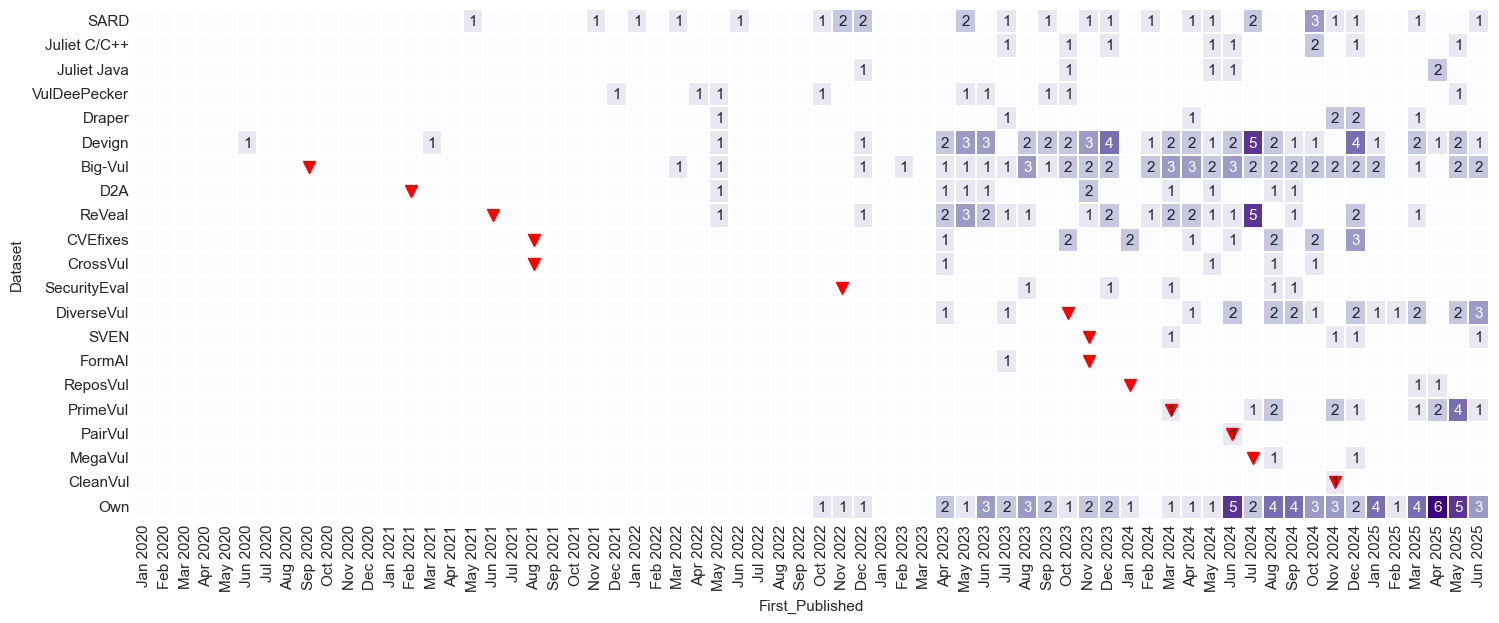

In [17]:
# trends & usage - heatmap
dataset_pub = {
  "Devign": "Dec 2019",
  "Big-Vul": "Sep 2020",
  "ReVeal": "Jun 2021",
  "SARD": None,
  "CVEfixes": "Aug 2021",
  "DiverseVul": "Oct 2023",
  "D2A": "Feb 2021",
  "VulDeePecker": "Jan 2018",
  "Juliet C/C++": "Oct 2017",
  "Juliet Java": "Oct 2017",
  "PrimeVul": "Mar 2024",
  "Draper": "Dec 2018",
  "SecurityEval": "Nov 2022",
  "CrossVul": "Aug 2021",
  "SVEN": "Nov 2023",
  "FormAI": "Nov 2023",
  "ReposVul": "Jan 2024",
  "PrimeVul": "Mar 2024",
  "MegaVul": "Jul 2024",
  "CleanVul": "Nov 2024",
  "PairVul": "Jun 2024",
} # arxiv: first versions

custom_order = ['SARD', 'Juliet C/C++', 'Juliet Java', 'VulDeePecker', 'Draper', 'Devign', 'Big-Vul', 'D2A', 'ReVeal', 'CVEfixes', 'CrossVul', 'SecurityEval', 'DiverseVul', 'SVEN', 'FormAI', 'ReposVul', 'PrimeVul', 'PairVul', 'MegaVul', 'CleanVul', 'Own']

custom_order_publication = [None, 'Oct 2017', 'Oct 2017', 'Jan 2018', 'Dec 2018', 'Dec 2019', 'Sep 2020', 'Feb 2021', 'Jun 2021', 'Aug 2021', 'Aug 2021', 'Nov 2022', 'Oct 2023', 'Nov 2023', 'Nov 2023', 'Jan 2024', 'Mar 2024', 'Jun 2024', 'Jul 2024', 'Nov 2024', None]

# Heatmap of selected datasets: distribution of dataset usage in studies over time
exploded_df['First_Published'] = pd.to_datetime(exploded_df['First_Published'], format='%b %Y')
exploded_df = exploded_df.sort_values(by='First_Published')
filtered_df = exploded_df[exploded_df['Dataset'].isin(custom_order)]
heatmap_data = filtered_df.groupby(['First_Published', 'Dataset']).size().unstack(fill_value=0)
heatmap_data.index = heatmap_data.index.strftime('%b %Y')

# Create a complete range of months from the start to end of your dataset
date_range = pd.date_range(start='Jan 2020', end='Jun 2025', freq='MS') # data available from Jun 2020 on; datasets: Oct 2017 ++
heatmap_data = heatmap_data.reindex(date_range.strftime('%b %Y'), fill_value=0)

heatmap_data = heatmap_data[custom_order]
 
# Plot heatmap
plt.figure(figsize=(_FIGSIZE_WIDTH, _FIGSIZE_HEIGHT))
annot_matrix = np.where(heatmap_data.T > 0, heatmap_data.T, "")
ax = sns.heatmap(heatmap_data.T, cmap="Purples", annot=annot_matrix, fmt="s", annot_kws={"size": _FONTSIZE_WITHIN_FIGURE}, linewidths=0.1, cbar=False,
                 xticklabels=date_range.strftime('%b %Y'), yticklabels=custom_order)

# Add markers for initial publication dates
for dataset, pub_date in zip(custom_order, custom_order_publication):
    if pub_date:  # Only proceed if a publication date is provided
        try:
            # Find the index of the publication date on the x-axis
            pub_index = list(heatmap_data.index).index(pub_date)
            # Find the index of the dataset on the y-axis
            dataset_index = custom_order.index(dataset)
            
            # Plot the marker
            plt.plot(pub_index + 0.5, dataset_index + 0.5, marker='v', color='red', markersize=8)
        except ValueError:
            # If the date is not in the heatmap's date range, skip it
            continue



# Labels and title
plt.xlabel("First_Published", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
plt.ylabel("Dataset", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
plt.xticks(fontsize=_FONTSIZE_TICKS)
plt.yticks(fontsize=_FONTSIZE_TICKS)

# Rotate x-axis labels for better readability
#plt.xticks(rotation=270)
#plt.xticks(ticks=np.arange(0, len(date_range), 4), labels=date_range.strftime('%b %Y')[::4], rotation=270)
plt.tick_params(axis='both', which='both', length=0)

# Show plot
plt.tight_layout()
plt.show()

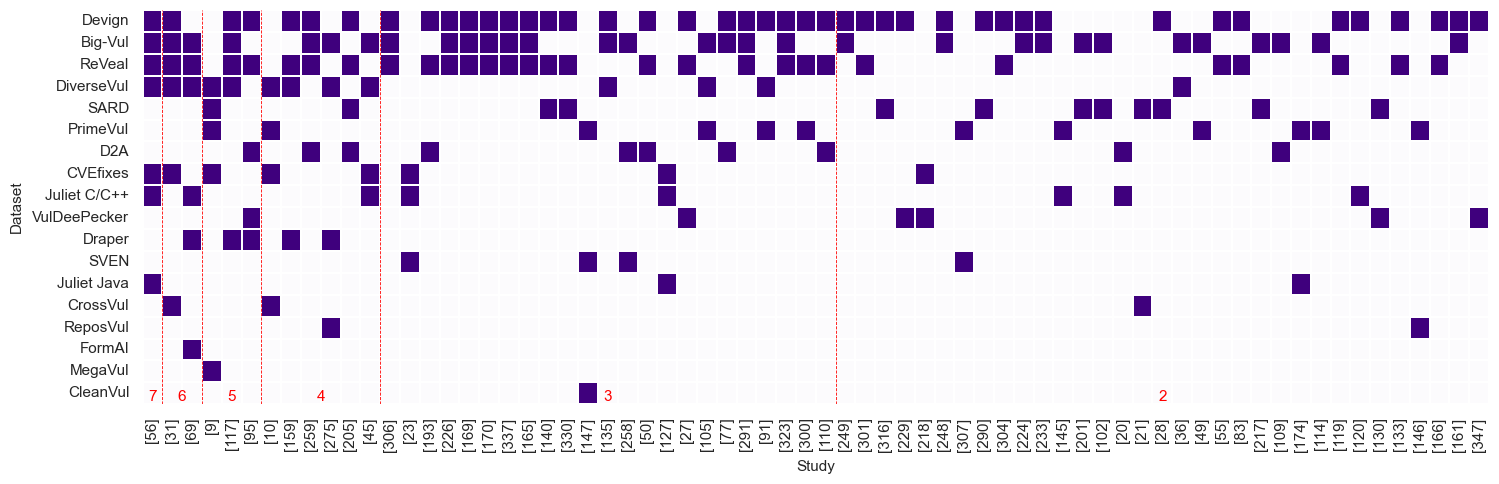

In [20]:
all_datasetsxstudy = datasetxstudies_bbl(taxonomy_df['CitationKey'].dropna().unique().tolist(), exploded_df[exploded_df['Dataset'].isin(selected_datasets)], citation_map, _figsize=(_FIGSIZE_WIDTH, 5))
# exploded_df[exploded_df['Dataset'].isin(selected_datasets)]

## All Datasets

In [21]:
dataset_counts_df = dataset_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
dataset_counts_df

,Dataset,Count
0,Own,71
1,Devign,53
2,Big-Vul,50
3,ReVeal,30
4,SARD,28
5,DiverseVul,21
6,PrimeVul,15
7,CVEfixes,14
8,D2A,10
9,VulDeePecker,9


In [22]:
# number of unique datasets 
# consider all named datasets
# own datasets: some are named, some not: manually check - add number of own - number of own named datasets (= 25)
# Subtract 1 for "Own" (not a specific dataset)
num_unique_datasets = dataset_counts_df['Dataset'].nunique() -1

# Number of "Own" entries (including named and unnamed)
num_own_total = dataset_counts_df[dataset_counts_df['Dataset'] == 'Own']['Count'].iloc[0]
# Number of named Own datasets (manually determined)
num_own_named = 25
num_own_unnamed = num_own_total - num_own_named

# Final total
total_unique_datasets = num_unique_datasets + num_own_unnamed
print(f"total number of unique datasets used: {total_unique_datasets}")

total number of unique datasets used: 158


In [23]:
### CONSIDER UNNAMED OWN DATASETS -- ADD FILTER 'Dataset == Own only named dataset
num_single_count = (dataset_counts_df['Count'] == 1).sum()
print(f"number of datasets used only once: {num_single_count + num_own_unnamed}")

number of datasets used only once: 126


### Example Use-Cases: LoRA, Prompt-Tuning, RAG, Agentic, Self-Verification, Hybrid - GNN

In [24]:
use_cases = ['Low-Rank Decomposition', 'RAG', 'Agentic', 'GNN']

use_case_references = {}
use_case_datasets = {}
use_case_dataset_dfs = {}

for case in use_cases:
    # Mask matching studies
    mask = taxonomy_df['Technique'].fillna('').str.contains(case, case=False) | \
           taxonomy_df['Architecture'].fillna('').str.contains(case, case=False)
    
    matched_df = taxonomy_df[mask]

    # Extract citation keys
    citations = matched_df['CitationKey'].dropna().unique().tolist()
    use_case_references[case] = citations

    # Extract and normalize dataset entries
    dataset_entries = matched_df['Dataset'].dropna().astype(str)
    all_datasets = []
    for entry in dataset_entries:
        if isinstance(entry, str):
            datasets = [ds.strip() for ds in entry.split(',')]
            all_datasets.extend(datasets)
        elif isinstance(entry, list):  # just in case
            all_datasets.extend(entry)

    # Store list of unique datasets for simple listing
    use_case_datasets[case] = sorted(set(all_datasets))

    # Count dataset occurrences and create DataFrame
    dataset_counter = Counter(all_datasets)
    df = pd.DataFrame(dataset_counter.items(), columns=['Dataset', 'Count']).sort_values(by='Count', ascending=False)
    use_case_dataset_dfs[case] = df

    # Print results
    print(f"\n=== {case} ===")
    print(f"{len(citations)} studies:")
    print("Dataset usage breakdown:")
    print(df.to_string(index=False))



=== Low-Rank Decomposition ===
17 studies:
Dataset usage breakdown:
              Dataset  Count
           DiverseVul      6
               Devign      5
              Big-Vul      4
               ReVeal      4
                  Own      4
                 SARD      2
             CVEfixes      2
             PrimeVul      2
              RealVul      1
                 SeVC      1
               Li2023      1
SQL Injection Dataset      1
                 SVEN      1
                 REEF      1
              Ponta19      1
              VCMatch      1
              Lin2017      1
               Draper      1
              LineVul      1
             Choi2017      1
             CrossVul      1
         Juliet C/C++      1
          Juliet Java      1
              PatchDB      1
             Lipp2022      1

=== RAG ===
17 studies:
Dataset usage breakdown:
         Dataset  Count
             Own      7
          Devign      4
         Big-Vul      4
          ReVeal      2
       

Low-Rank Decomposition


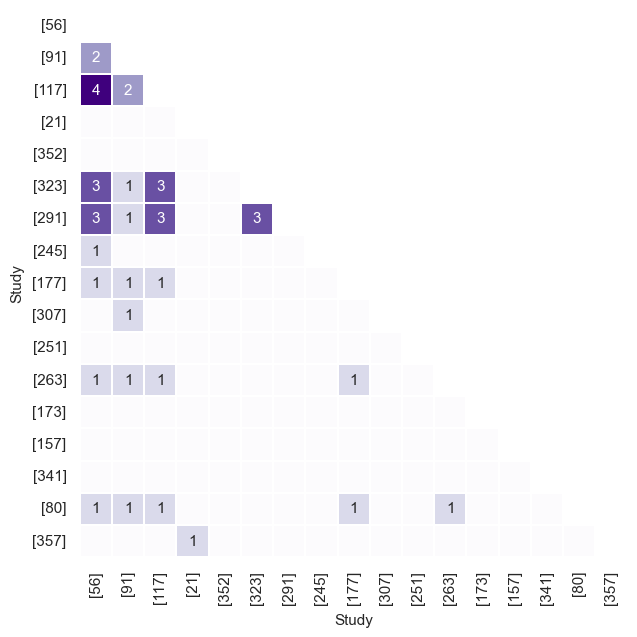

RAG


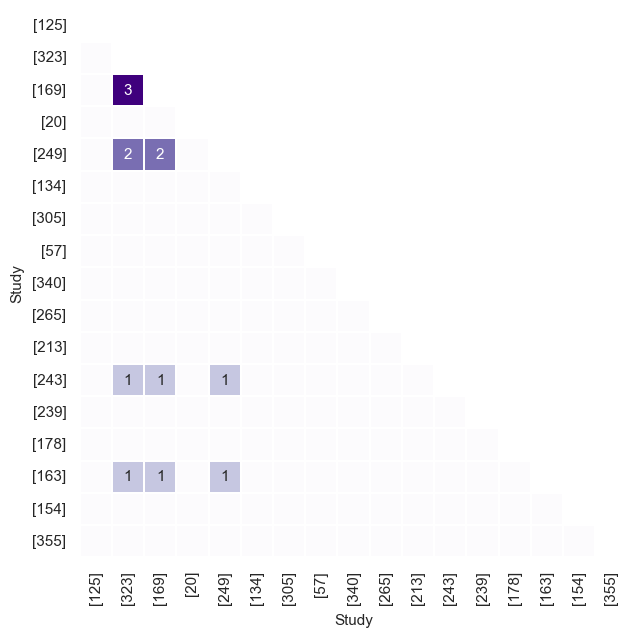

Agentic


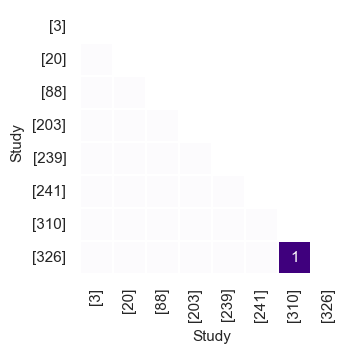

GNN


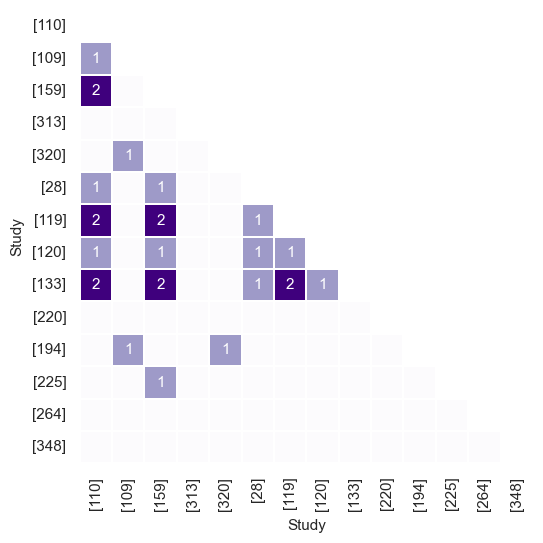

In [25]:
for case, references in use_case_references.items():
    print(case)
    studies = studyxstudy_bbl(references, exploded_df, citation_map, scale_per_study_cm=0.8, label_buffer_cm=3, output_file=case)

## Qualitative Categorization

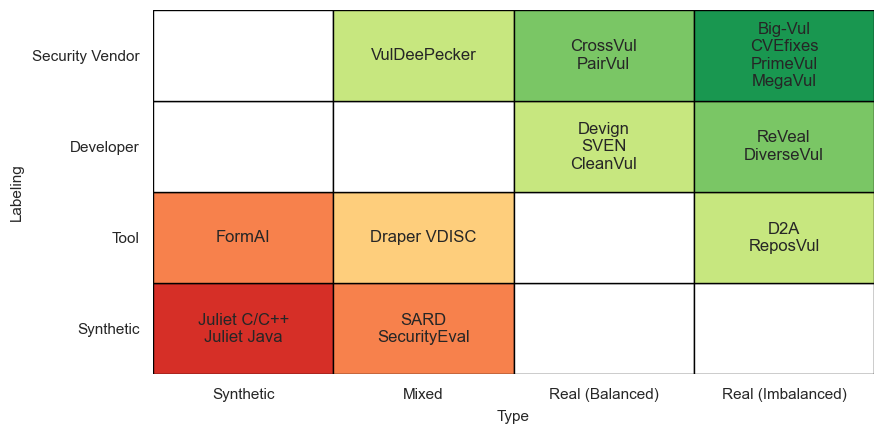

In [31]:
# Load CSV file
df = pd.read_csv("datasets_labeling_summary.csv")

# fixed axis ordering
x_order = ["Synthetic", "Mixed", "Real (Balanced)", "Real (Imbalanced)"]  # left to right (worst to best)
y_order = ["Synthetic", "Tool", "Developer", "Security Vendor"]  # bottom to top (worst to best)

# dictionary to group datasets by (x, y) cell
cell_data = {}
for _, row in df.iterrows():
    x_idx = x_order.index(row["Type"])
    y_idx = y_order.index(row["Labeling"])
    key = (x_idx, y_idx)
    if key not in cell_data:
        cell_data[key] = []
    cell_data[key].append(row["Dataset"])

# helper to truncate colormap
def truncate_colormap(cmap, minval=0.15, maxval=0.85, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# avoid dark extremes
base_cmap =  matplotlib.colormaps["RdYlGn"]
cmap = truncate_colormap(base_cmap, 0.1, 0.9)


fig, ax = plt.subplots(figsize=(9, 4.5))
max_x = len(x_order) - 1
max_y = len(y_order) - 1
for x in range(len(x_order)):
    for y in range(len(y_order)):
        key = (x, y)
        norm_x = x / max_x
        norm_y = y / max_y
        blend = (norm_x + norm_y) / 2
        color = cmap(blend)
        # Always draw full rectangle (colored or white if empty)
        if key in cell_data:
            datasets = cell_data[key]
            text = "\n".join(datasets)
            ax.add_patch(Rectangle((x, y), 1, 1, color=color, ec='black'))
            ax.text(x + 0.5, y + 0.5, text, ha='center', va='center', fontsize=12)
        else:
            # Empty but still draw full rectangle with background color
            ax.add_patch(Rectangle((x, y), 1, 1, color='white', ec='black'))

ax.set_xlim(0, len(x_order))
ax.set_ylim(0, len(y_order))
ax.set_xticks([i + 0.5 for i in range(len(x_order))])
ax.set_xticklabels(x_order, fontsize=_FONTSIZE_TICKS)
ax.set_yticks([i + 0.5 for i in range(len(y_order))])
ax.set_yticklabels(y_order, fontsize=_FONTSIZE_TICKS)  # no reverse

ax.set_xlabel("Type", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)
ax.set_ylabel("Labeling", fontsize=_FONTSIZE_AXIS_LABELS, labelpad=_LABELPAD)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.tight_layout()
plt.show()

## Dataset x Dataset Comparability


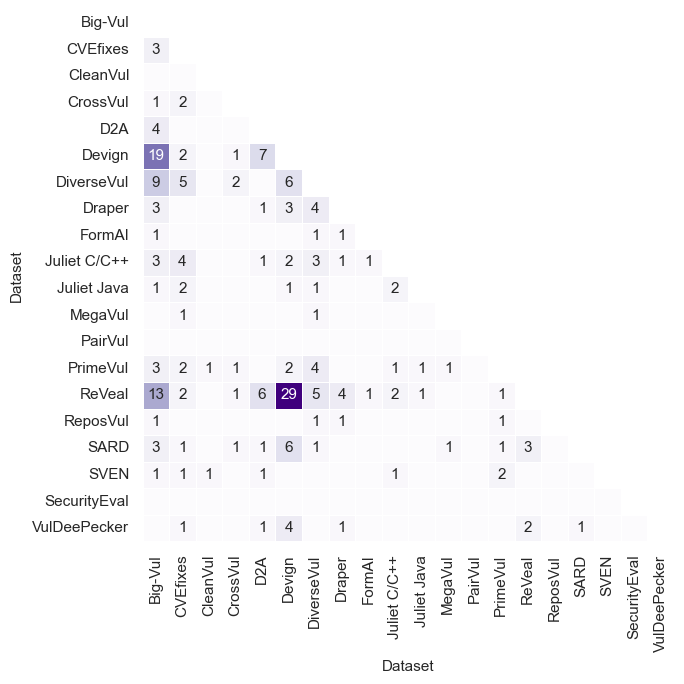

In [32]:
all_studies = datasetxdataset(taxonomy_df['CitationKey'].dropna().unique().tolist(), exploded_df[exploded_df['Dataset'].isin(selected_datasets)], 20, (7,7))

# Datasets - CWE Coverage and Diversity

<span style="color:red">### !! The following analysis uses datasets by other studies. We do not upload the sources of the datasets but refer to the original sources (links to the repositories of the datasets are listed in the README.md file)</span>

#### [VulDeePecker](https://github.com/CGCL-codes/VulDeePecker/tree/master)
- 61638 code gadgets, including 17725 code gadgets that are vulnerable and 43913 code gadgets that are not vulnerable

In [170]:
def parse_cgd_file(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        while True:
            header = f.readline()
            if not header:
                break  # eof
            
            # parse header
            parts = header.strip().split(maxsplit=3)
            if len(parts) < 4:
                continue  # Skip malformed lines
            gadget_id, file_path, func_type, line_no = parts

            # Read code snippet
            code_lines = []
            while True:
                line = f.readline()
                if line.strip() in {'0', '1'}:
                    label = int(line.strip())  # Vulnerability label
                    break
                code_lines.append(line.rstrip())

            # Skip separator line
            f.readline()

            # Store the parsed gadget
            data.append({
                'gadget_id': int(gadget_id),
                'file_path': file_path,
                'func_type': func_type,
                'line_no': int(line_no),
                'code': '\n'.join(code_lines),
                'label': label
            })

    return pd.DataFrame(data)

# parse CWE-119 gadgets
df_vdp_cwe119 = parse_cgd_file('datasets/VulDeePecker/cwe119_cgd.txt')
df_vdp_cwe399 = parse_cgd_file('datasets/VulDeePecker/cwe399_cgd.txt')

print(f"total number of code gadgets: {df_vdp_cwe119.shape[0] + df_vdp_cwe399.shape[0]}")

total number of code gadgets: 61638


In [171]:
## df_vdp_cwe_stats
# filter vulnerable entries (label == 1)
df_vdp_cwe119_vulnerable = df_vdp_cwe119[df_vdp_cwe119['label'] == 1]
df_vdp_cwe399_vulnerable = df_vdp_cwe399[df_vdp_cwe399['label'] == 1]

# statistics
count_cwe119 = df_vdp_cwe119_vulnerable.shape[0]
count_cwe399 = df_vdp_cwe399_vulnerable.shape[0]
total_vulnerable = count_cwe119 + count_cwe399
print(f"total number of vulnerable code gadgets: {total_vulnerable}")

# Build the DataFrame
df_vdp_cwe_stats = pd.DataFrame({
    'cwe': ['CWE-119', 'CWE-399'],
    'count': [count_cwe119, count_cwe399],
    'percentage': [100 * count_cwe119 / total_vulnerable, 100 * count_cwe399 / total_vulnerable],
    'dataset': "VulDeePecker"
})

# Round percentage (optional)
df_vdp_cwe_stats['percentage'] = df_vdp_cwe_stats['percentage'].round(2)
df_vdp_cwe_stats

total number of vulnerable code gadgets: 17725


,cwe,count,percentage,dataset
0,CWE-119,10440,58.9,VulDeePecker
1,CWE-399,7285,41.1,VulDeePecker


#### [VDISC Draper](https://osf.io/d45bw/)




In [172]:
with h5py.File('datasets/Draper/VDISC_train.hdf5', 'r') as f:
    print(list(f.keys()))  # identify format

['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other', 'functionSource']


In [173]:
def load_hdf5_file(filepath):
    with h5py.File(filepath, 'r') as f:
        # load function source code (decode from bytes to string)
        source_code = [x.decode('utf-8') for x in f['functionSource'][:]]
        # load each CWE label
        labels = {
            cwe: f[cwe][:] for cwe in ['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other']
        }
    return source_code, labels

# load splits
src_train, lbl_train = load_hdf5_file('datasets/Draper/VDISC_train.hdf5')
src_val, lbl_val = load_hdf5_file('datasets/Draper/VDISC_validate.hdf5')
src_test, lbl_test = load_hdf5_file('datasets/Draper/VDISC_test.hdf5')

# combine splits
all_source = src_train + src_val + src_test
all_labels = {
    cwe: np.concatenate([lbl_train[cwe], lbl_val[cwe], lbl_test[cwe]])
    for cwe in lbl_train
}

# to pandas dataframe
df_draper = pd.DataFrame({'source_code': all_source, **all_labels  # expands each CWE column
})
print(f"total functions: {df_draper.shape[0]}")


total functions: 1274366


In [174]:
## df_Draper_cwe_stats
# filter vulnerable functions (any label is true)
df_draper_vul = df_draper[df_draper[['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other']].any(axis=1)]
print(f"vulnerable functions (functions may have more than one detected CWE each): {df_draper_vul.shape[0]}")

# group by CWE-ID, calculate size and percentage
# Melt the CWE columns into 'CWE ID' and 'label'
melted = df_draper_vul.melt(
    id_vars=['source_code'], 
    value_vars=['CWE-119', 'CWE-120', 'CWE-469', 'CWE-476', 'CWE-other'], 
    var_name='cwe', 
    value_name='label'
)
# Keep only rows where the CWE label is True
melted = melted[melted['label'] == True]
# Group by CWE ID
df_draper_cwe_stats = melted.groupby('cwe').size().reset_index(name='count')
df_draper_cwe_stats['percentage'] = 100 * df_draper_cwe_stats['count'] / df_draper_cwe_stats['count'].sum()
df_draper_cwe_stats['percentage'] = df_draper_cwe_stats['percentage'].round(2)
df_draper_cwe_stats['dataset'] = "Draper"
df_draper_cwe_stats.sort_values('count', ascending=False)

df_draper_cwe_stats


vulnerable functions (functions may have more than one detected CWE each): 82411


,cwe,count,percentage,dataset
0,CWE-119,24157,19.87,Draper
1,CWE-120,47660,39.21,Draper
2,CWE-469,2625,2.16,Draper
3,CWE-476,12094,9.95,Draper
4,CWE-other,35028,28.81,Draper


#### [Big-Vul](https://github.com/ZeoVan/MSR_20_Code_vulnerability_CSV_Dataset)


The official commit-level dataset is provided in ``all_c_cpp_release2.0.csv``, containing 4432 commits.

Further, a cleaned version of split functions is provided in ``MSR_data_cleaned.csv``. This function-level dataset, however, does not match the statistics provided in the paper, containing only 188636 functions in total, with 10900 vulnerable functions across 88 CWEs (paper reported 11823 vulnerable and 253096 non-vulnerable functions, 91 different CWEs); cf. [issue](https://github.com/ZeoVan/MSR_20_Code_vulnerability_CSV_Dataset/issues/10); not all CWEs present in vulnerable examples



In [175]:
df_bigvul = pd.read_csv('datasets/Big-Vul/all_c_cpp_release2.0.csv', sep=',', index_col=0) # original commit datasets
df_msr_cleaned = pd.read_csv('datasets/Big-Vul/MSR_data_cleaned.csv', sep=',', index_col=0, low_memory=False) # cleaned version of split functions; 

# Statistics 
print(f"Big-Vul:")
print(f"{df_bigvul.shape[0]} commits")

total_funcs = df_msr_cleaned.shape[0]
vuln_funcs = (df_msr_cleaned['vul'] == 1).sum()
print(f"{total_funcs} functions; {vuln_funcs} vulnerable functions")

Big-Vul:
4432 commits
188636 functions; 10900 vulnerable functions


In [287]:
num_unique_cwes = df_msr_cleaned["CWE ID"].explode().nunique()
print(f"{num_unique_cwes} CWE IDs;")

91 CWE IDs;


In [176]:
## df_bigvul_cwe_stats
# # Group by CWE-ID, calculate size and percentage
df_vul = df_msr_cleaned[df_msr_cleaned['vul'] == 1]
df_bigvul_cwe_stats = df_vul.groupby('CWE ID').size().reset_index(name='count')
df_bigvul_cwe_stats = df_bigvul_cwe_stats.rename(columns={'CWE ID': 'cwe'})
df_bigvul_cwe_stats['percentage'] = 100 * df_bigvul_cwe_stats['count'] / df_bigvul_cwe_stats['count'].sum()
df_bigvul_cwe_stats['percentage'] = df_bigvul_cwe_stats['percentage'].round(2)
df_bigvul_cwe_stats['dataset'] = 'Big-Vul'

# Sort
df_bigvul_cwe_stats = df_bigvul_cwe_stats.sort_values('count', ascending=False)
df_bigvul_cwe_stats.head(10)

,cwe,count,percentage,dataset
1,CWE-119,2127,24.22,Big-Vul
14,CWE-20,1142,13.00,Big-Vul
45,CWE-399,736,8.38,Big-Vul
3,CWE-125,625,7.12,Big-Vul
21,CWE-264,508,5.78,Big-Vul
15,CWE-200,503,5.73,Big-Vul
10,CWE-189,337,3.84,Big-Vul
49,CWE-416,330,3.76,Big-Vul
12,CWE-190,307,3.50,Big-Vul
42,CWE-362,278,3.17,Big-Vul


#### [CVEfixes](https://zenodo.org/records/13118970) ([Docs](https://github.com/secureIT-project/CVEfixes))

- 12107 VFCs for a total of 11873 CVEs in 272 different CWE types
- source code before and after changing 51342 files and 138974 functions

In [177]:
## sql database
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
from sqlite3 import Error
from pathlib import Path
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.ticker as tick
import requests
import difflib as diff
import re 
import csv
import ast

def create_connection(db_file):
    """
    create a connection to sqlite3 database
    """
    conn = None
    try:
        conn = lite.connect(db_file, timeout=10)  # connection via sqlite3
    except Error as e:
        print(e)
    return conn

conn = create_connection("datasets/CVEfixes/CVEfixes_v1.0.8/data/cvefixes.db")

In [178]:
pd.read_sql_query("SELECT COUNT(*) as total_commits FROM commits;", conn)

,total_commits
0,12107


In [179]:
pd.read_sql_query("SELECT COUNT(*) as total_files FROM file_change;", conn)

,total_files
0,51342


In [180]:
pd.read_sql_query("SELECT before_change, COUNT(*) as total_methods FROM method_change GROUP BY before_change;", conn)

,before_change,total_methods
0,False,151349
1,True,126599


In [181]:
pd.read_sql_query("SELECT COUNT(*) as total_vul_methods FROM method_change WHERE before_change = 'True';", conn)


,total_vul_methods
0,126599


In [182]:
pd.read_sql_query("SELECT COUNT(*) as total_methods FROM method_change;", conn)

,total_methods
0,277948


In [183]:
pd.read_sql_query("SELECT COUNT(*) as total_cwes FROM cwe;", conn)

,total_cwes
0,272


In [184]:
## df_cvefixes_cwe_stats
# SQL query to link methods to CWEs and count vulnerable methods per CWE
sql_query = """
SELECT 
    cwe.cwe_id AS cwe,
    COUNT(mc.method_change_id) AS count
FROM 
    method_change mc, file_change fc, commits c, fixes f, cve cve, cwe_classification cwe
WHERE mc.before_change = 'True'
AND   mc.file_change_id = fc.file_change_id
AND   fc.hash = c.hash
AND   c.hash = f.hash
AND   f.cve_id = cve.cve_id
AND   cve.cve_id = cwe.cve_id
GROUP BY 
    cwe.cwe_id
ORDER BY 
    count DESC;
"""

# Execute and load into pandas
df_cvefixes_cwe_stats = pd.read_sql_query(sql_query, conn)

# Calculate percentages relative to ALL vulnerable methods
total_vuln_methods = pd.read_sql_query("SELECT COUNT(*) AS count FROM method_change WHERE before_change = 'True';", conn).values[0][0]
df_cvefixes_cwe_stats['percentage'] = 100 * df_cvefixes_cwe_stats['count'] / total_vuln_methods
df_cvefixes_cwe_stats['percentage'] = df_cvefixes_cwe_stats['percentage'].round(2)
df_cvefixes_cwe_stats['dataset'] = 'CVEfixes'
df_cvefixes_cwe_stats.head(10)


,cwe,count,percentage,dataset
0,CWE-79,50602,39.97,CVEfixes
1,CWE-78,14497,11.45,CVEfixes
2,CWE-89,12607,9.96,CVEfixes
3,CWE-94,9955,7.86,CVEfixes
4,NVD-CWE-noinfo,8300,6.56,CVEfixes
5,CWE-22,5331,4.21,CVEfixes
6,NVD-CWE-Other,5149,4.07,CVEfixes
7,CWE-918,4476,3.54,CVEfixes
8,CWE-400,3824,3.02,CVEfixes
9,CWE-434,3447,2.72,CVEfixes


In [185]:
total_count_cwe_labels = df_cvefixes_cwe_stats['count'].sum()
print(f"Total sum of all CWE labels: {int(total_count_cwe_labels)}")

Total sum of all CWE labels: 154285


In [186]:
df_cvefixes_cwe_stats['percentage'] = 100 * df_cvefixes_cwe_stats['count'] / total_count_cwe_labels
df_cvefixes_cwe_stats['percentage'] = df_cvefixes_cwe_stats['percentage'].round(2)
df_cvefixes_cwe_stats.head(10)

,cwe,count,percentage,dataset
0,CWE-79,50602,32.80,CVEfixes
1,CWE-78,14497,9.40,CVEfixes
2,CWE-89,12607,8.17,CVEfixes
3,CWE-94,9955,6.45,CVEfixes
4,NVD-CWE-noinfo,8300,5.38,CVEfixes
5,CWE-22,5331,3.46,CVEfixes
6,NVD-CWE-Other,5149,3.34,CVEfixes
7,CWE-918,4476,2.90,CVEfixes
8,CWE-400,3824,2.48,CVEfixes
9,CWE-434,3447,2.23,CVEfixes


In [187]:
num_cwes = df_cvefixes_cwe_stats['cwe'].nunique()
print(f"Number of CWE groups: {num_cwes}")

Number of CWE groups: 224


In [189]:
conn.close()

#### [CrossVul](https://zenodo.org/records/4734050)

- 27476 files, 13738 vulnerable files, 168 CWEs


In [190]:
## df_crossvul_cwe_stats
def analyze_crossvul(base_dir):
    cwe_data = []
    total_vuln_files = 0
    total_files = 0

    # Iterate through CWE folders (including "None")
    for cwe_dir in os.listdir(base_dir):
        cwe_path = os.path.join(base_dir, cwe_dir)
        if os.path.isdir(cwe_path) and (cwe_dir.startswith('CWE-') or cwe_dir == 'None'):
            vuln_count = 0
            good_count = 0

            # Iterate through language subfolders
            for lang_dir in os.listdir(cwe_path):
                lang_path = os.path.join(cwe_path, lang_dir)
                if os.path.isdir(lang_path):
                    files = os.listdir(lang_path)
                    vuln_count += len([f for f in files if f.startswith('bad_')])
                    good_count += len([f for f in files if f.startswith('good_')])

            total_cwe_files = vuln_count + good_count
            total_vuln_files += vuln_count
            total_files += total_cwe_files

            cwe_data.append({
                'cwe': cwe_dir,
                'vulnerable_files': vuln_count
            })

    # Convert to DataFrame
    df = pd.DataFrame(cwe_data)

    # Sort
    df = df[['cwe', 'vulnerable_files']].rename(columns={'vulnerable_files': 'count'})
    df['percentage'] = 100 * (df['count'] / total_vuln_files)
    df['percentage'] = df['percentage'].round(2)
    df = df.sort_values('percentage', ascending=False).reset_index(drop=True)
    df['dataset'] = 'CrossVul'

    return df, total_vuln_files, total_files


# Example usage
df_crossvul_cwe_stats, total_vuln, total_all = analyze_crossvul('datasets/CrossVul/dataset_final_sorted')

# Output
print(f"Total vulnerable files: {total_vuln}")
print(f"Total files: {total_all}")
print(f"Unique CWEs: {df_crossvul_cwe_stats.shape[0]}")
df_crossvul_cwe_stats.head(10)


Total vulnerable files: 13738
Total files: 27476
Unique CWEs: 168


,cwe,count,percentage,dataset
0,CWE-79,2047,14.90,CrossVul
1,CWE-20,1014,7.38,CrossVul
2,CWE-125,979,7.13,CrossVul
3,CWE-119,862,6.27,CrossVul
4,None,671,4.88,CrossVul
5,CWE-200,667,4.86,CrossVul
6,CWE-89,540,3.93,CrossVul
7,CWE-264,533,3.88,CrossVul
8,CWE-352,471,3.43,CrossVul
9,CWE-22,398,2.90,CrossVul


#### [SecurityEval](https://github.com/s2e-lab/SecurityEval?tab=readme-ov-file)

- 121 prompts/programs, 69 cwes

In [191]:
def read_jsonl_ijson(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        rows = [json.loads(line) for line in f]
    return pd.DataFrame(rows)

df_securityeval = read_jsonl_ijson('datasets/SecurityEval/dataset.jsonl')

In [192]:
## df_securityeval_cwe_stats
# extract CWE IDs from 'ID' (e.g., CWE-020)
df_securityeval['cwe'] = df_securityeval['ID'].apply(lambda x: re.match(r'CWE-\d+', x).group(0) if re.match(r'CWE-\d+', x) else None)

# group by CWE, count, and calculate percentage
df_securityeval_cwe_stats = df_securityeval.groupby('cwe').size().reset_index(name='count')
df_securityeval_cwe_stats['percentage'] = 100 * df_securityeval_cwe_stats['count'] / df_securityeval_cwe_stats['count'].sum()
df_securityeval_cwe_stats['percentage'] = df_securityeval_cwe_stats['percentage'].round(2)
df_securityeval_cwe_stats = df_securityeval_cwe_stats.sort_values('count', ascending=False).reset_index(drop=True)
df_securityeval_cwe_stats['dataset'] = 'SecurityEval'

df_securityeval_cwe_stats.head(10)

,cwe,count,percentage,dataset
0,CWE-020,6,4.96,SecurityEval
1,CWE-611,6,4.96,SecurityEval
2,CWE-601,5,4.13,SecurityEval
3,CWE-502,4,3.31,SecurityEval
4,CWE-022,4,3.31,SecurityEval
5,CWE-327,4,3.31,SecurityEval
6,CWE-117,3,2.48,SecurityEval
7,CWE-730,3,2.48,SecurityEval
8,CWE-703,3,2.48,SecurityEval
9,CWE-295,3,2.48,SecurityEval


#### [SVEN](https://github.com/eth-sri/sven)

- 1,606 programs (i.e., 803 pairs)

In [193]:
## df_sven_cwe_stats
def read_sven_jsonl_files(directory):
    all_records = []
    for file in os.listdir(directory):
        if file.endswith('.jsonl'):  # Adjust to JSONL
            cwe_id = file.split('.')[0]  # e.g., 'cwe-022'
            file_path = os.path.join(directory, file)
            df = pd.read_json(file_path, lines=True)  # Read as JSONL
            df['cwe'] = cwe_id  # Add CWE column
            all_records.append(df)
    return pd.concat(all_records, ignore_index=True)

# Directories (adjust paths as needed)
train_dir = 'datasets/SVEN/data_train_val/train'
val_dir = 'datasets/SVEN/data_train_val/val'

# Read train data
df_train = read_sven_jsonl_files(train_dir)
df_val = read_sven_jsonl_files(val_dir)
df_all = pd.concat([df_train, df_val], ignore_index=True)

# Group by CWE, count and calculate percentages
df_sven_cwe_stats = df_all.groupby('cwe').size().reset_index(name='count')
df_sven_cwe_stats['percentage'] = 100 * df_sven_cwe_stats['count'] / df_sven_cwe_stats['count'].sum()
df_sven_cwe_stats['percentage'] = df_sven_cwe_stats['percentage'].round(2)
df_sven_cwe_stats = df_sven_cwe_stats.sort_values('count', ascending=False).reset_index(drop=True)
df_sven_cwe_stats['dataset'] = 'SVEN'

df_sven_cwe_stats


,cwe,count,percentage,dataset
0,cwe-089,204,25.40,SVEN
1,cwe-125,145,18.06,SVEN
2,cwe-078,106,13.20,SVEN
3,cwe-476,78,9.71,SVEN
4,cwe-416,64,7.97,SVEN
5,cwe-022,57,7.10,SVEN
6,cwe-787,56,6.97,SVEN
7,cwe-079,50,6.23,SVEN
8,cwe-190,43,5.35,SVEN


#### [DiverseVul](https://drive.google.com/file/d/12IWKhmLhq7qn5B_iXgn5YerOQtkH-6RG/view?usp=sharing) [Git](https://github.com/wagner-group/diversevul?tab=readme-ov-file)

- 18945 vulnerable functions and 150 CWEs; but: total functions: 330492 (paper stated 330492 non-vulnerable functions)

In [194]:
df_diversevul = read_jsonl_ijson('datasets/DiverseVul/diversevul_20230702.json')

In [195]:
total_funcs = df_diversevul.shape[0]
vuln_funcs = df_diversevul[df_diversevul['target'] == True].shape[0]

print(f"total functions: {total_funcs}")
print(f"vulnerable functions: {vuln_funcs}")

total functions: 330492
vulnerable functions: 18945


In [196]:
## df_diversevul_cwe_stats
# Group by CWE, count, and calculate percentage
# filter out rows with empty CWE lists or nulls (if any)
df_primevul_with_cwe = df_diversevul[df_diversevul['cwe'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
# explode CWE lists
df_diversevul_with_cwe_exploded = df_primevul_with_cwe.explode('cwe')

df_diversevul_cwe_stats = df_diversevul_with_cwe_exploded.groupby('cwe').size().reset_index(name='count')
df_diversevul_cwe_stats['percentage'] = 100 * df_diversevul_cwe_stats['count'] / df_diversevul_cwe_stats['count'].sum()
df_diversevul_cwe_stats['percentage'] = df_diversevul_cwe_stats['percentage'].round(2)
df_diversevul_cwe_stats = df_diversevul_cwe_stats.sort_values('count', ascending=False)
df_diversevul_cwe_stats['dataset'] = 'DiverseVul'
df_diversevul_cwe_stats.head(10)

,cwe,count,percentage,dataset
125,CWE-787,39343,10.92,DiverseVul
8,CWE-125,28180,7.82,DiverseVul
110,CWE-703,25208,7.00,DiverseVul
4,CWE-119,25036,6.95,DiverseVul
22,CWE-20,22870,6.35,DiverseVul
76,CWE-416,22671,6.29,DiverseVul
86,CWE-476,18359,5.09,DiverseVul
23,CWE-200,12770,3.54,DiverseVul
18,CWE-190,10984,3.05,DiverseVul
71,CWE-400,9698,2.69,DiverseVul


#### [FormAI](https://github.com/FormAI-Dataset/FormAI-dataset)

- v1: number of vulnerabilities detected by ESBMC is 197800
- manual CWE mapping not part of dataset, only paper artefact; exclude from further analysis

In [290]:
# v1
df_formai_v1 = pd.read_csv('datasets/FormAI/FormAI_dataset.csv')
total_funcs = df_formai_v1.shape[0]
vuln_funcs = df_formai_v1[df_formai_v1['Vulnerability type'] == "VULNERABLE"].shape[0]

print(f"total functions: {total_funcs}")
print(f"vulnerable functions: {vuln_funcs}")
print(df_formai_v1.columns)

df_vul = df_formai_v1[df_formai_v1['Vulnerability type'] == 'VULNERABLE']

# Group by error_type (similar to CWE), count and calculate percentages
grouped = df_vul.groupby('Error type').size().reset_index(name='count')
grouped['percentage'] = 100 * grouped['count'] / grouped['count'].sum()

# Sort by descending count
grouped = grouped.sort_values('count', ascending=False)
grouped.head(10)

total functions: 246549
vulnerable functions: 197800
Index(['Filename', 'Vulnerability type', 'Source code', 'Function name',
       'Line', 'Error type'],
      dtype='object')


,Error type,count,percentage
1850,buffer overflow on scanf,86472,43.716886
1854,dereference failure: NULL pointer,31829,16.091507
1960,dereference failure: array bounds violated,24702,12.488372
2014,dereference failure: invalid pointer,9823,4.966127
12,arithmetic overflow on sub,6425,3.248231
2,arithmetic overflow on add,4904,2.479272
9,arithmetic overflow on mul,3692,1.866532
6,arithmetic overflow on floating-point ieee_mul,2966,1.499494
5,arithmetic overflow on floating-point ieee_div,1604,0.810920
1849,buffer overflow on fscanf,1577,0.797270


In [291]:
# v2
with open('datasets/FormAI/FormAI-v2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_formai = pd.DataFrame(data)
total_funcs = df_formai.shape[0]
vuln_funcs = df_formai[df_formai['category'] == "VULNERABLE"].shape[0]

print(f"total functions: {total_funcs}")
print(f"vulnerable functions: {vuln_funcs}")

total functions: 883140
vulnerable functions: 765366


In [ ]:
print(df_formai.columns)

# Filter only VULNERABLE entries (if needed)
df_vul = df_formai[(df_formai['category'] == "VULNERABLE") & (df_formai['verification_finished'] == "yes")]

# Group by error_type (similar to CWE), count and calculate percentages
grouped = df_vul.groupby('error_type').size().reset_index(name='count')
grouped['percentage'] = 100 * grouped['count'] / grouped['count'].sum()

# Sort by descending count
grouped = grouped.sort_values('count', ascending=False)

Index(['category', 'file_name', 'verification_finished', 'vulnerable_line',
       'column', 'function', 'violated_property', 'stack_trace', 'error_type',
       'code_snippet', 'source_code', 'num_lines', 'cyclomatic_complexity'],
      dtype='object')


,error_type,count,percentage
22,dereference failure: NULL pointer,285706,38.403254
18,buffer overflow on scanf,210356,28.275062
28,dereference failure: invalid pointer,73342,9.858286
26,dereference failure: array bounds violated,22181,2.981465
15,array bounds violated: upper bound,20727,2.786026
27,dereference failure: forgotten memory,20267,2.724195
14,array bounds violated: lower bound,17876,2.402808
13,arithmetic overflow on sub,17148,2.304953
3,arithmetic overflow on add,15233,2.047548
10,arithmetic overflow on mul,12049,1.619570


#### [ReposVul](https://drive.google.com/file/d/1szQ9FnIC_onQRu_TjZ2uofkjv9z_s4pv/view?usp=drive_link) ([Docs](https://github.com/Eshe0922/ReposVul))

- filtered (non-outdated): 1494 projects with 226 different CWEs
- (all): 1534 projects with 235 CWEs


- total number of functions reported in the paper: 262,216;
- what we could reproduce: 232465
- overall 236 CWEs, but only 111 unique CWEs in vulnerable functions (target = 1)


In [262]:
def ensure_list(x):
    if isinstance(x, list):
        return x
    elif x is None:
        return []
    else:
        return [x]

def analyze_reposvul_details_list(filepath: str, dataset_name: str = "ReposVul"):
    num_vuln = 0
    num_non_vuln = 0
    vulnerable_samples_cwes = []

    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            try:
                entry = json.loads(line)

                cwe_ids = ensure_list(entry.get("cwe_id"))
                if isinstance(cwe_ids, list) and any(isinstance(c, dict) for c in cwe_ids):
                    # skip malformed entries
                    continue

                details_list = entry.get("details", [])
                if not isinstance(details_list, list):
                    continue

                for file_entry in details_list:
                    # Skip if no function-level info
                    func_before = ensure_list(file_entry.get("function_before"))
                    func_after = ensure_list(file_entry.get("function_after"))

                    for f in func_before:
                        if not isinstance(f, dict):
                            continue
                        code = f.get("function")
                        label = f.get("target", 0)
                        if code:
                            if label == 1:
                                num_vuln += 1
                                for cwe in cwe_ids:
                                    if cwe:
                                        vulnerable_samples_cwes.append(cwe)
                            else:
                                num_non_vuln += 1

                    for f in func_after:
                        if not isinstance(f, dict):
                            continue
                        code = f.get("function")
                        label = f.get("target", 0)
                        if code:
                            if label == 1:
                                num_vuln += 1
                                for cwe in cwe_ids:
                                    if cwe:
                                        vulnerable_samples_cwes.append(cwe)
                            else:
                                num_non_vuln += 1

            except Exception as e:
                print(f"Line {i} skipped: {e}")
                continue

    num_total = num_vuln + num_non_vuln
    cwe_counts = Counter(vulnerable_samples_cwes)

    if num_vuln == 0:
        print("No vulnerable functions found.")
        return pd.DataFrame(columns=["cwe", "count", "percentage", "dataset"])

    result_df = pd.DataFrame([
        {
            "cwe": cwe,
            "count": count,
            "percentage": round(count / num_vuln * 100, 2),
            "dataset": dataset_name
        }
        for cwe, count in cwe_counts.items()
    ]).sort_values(by="count", ascending=False).reset_index(drop=True)

    print("\n--- ReposVul (Function-Level) ---")
    print(f"Vulnerable functions:        {num_vuln}")
    print(f"Non-vulnerable functions:    {num_non_vuln}")
    print(f"Total functions:             {num_total}")
    print(f"Unique CWE types:            {len(result_df)}")

    return result_df

df_reposvul_cwe_stats = analyze_reposvul_details_list("datasets/ReposVul/ReposVul.jsonl", "ReposVul")
df_reposvul_cwe_stats.head(10)


--- ReposVul (Function-Level) ---
Vulnerable functions:        1718
Non-vulnerable functions:    230747
Total functions:             232465
Unique CWE types:            111


,cwe,count,percentage,dataset
0,CWE-119,207,12.05,ReposVul
1,CWE-787,150,8.73,ReposVul
2,CWE-190,149,8.67,ReposVul
3,CWE-125,123,7.16,ReposVul
4,CWE-20,121,7.04,ReposVul
5,CWE-611,110,6.40,ReposVul
6,CWE-79,67,3.90,ReposVul
7,CWE-22,66,3.84,ReposVul
8,NVD-CWE-noinfo,61,3.55,ReposVul
9,CWE-200,52,3.03,ReposVul


In [285]:
# reposvul %Vuln
(1718 / 232465) * 100

0.7390359839115566

In [263]:
df_reposvul_Java = analyze_reposvul_details_list("datasets/ReposVul/ReposVul_java.jsonl", "ReposVul_Java")
df_reposvul_Java.head(10)


--- ReposVul (Function-Level) ---
Vulnerable functions:        173
Non-vulnerable functions:    2869
Total functions:             3042
Unique CWE types:            23


,cwe,count,percentage,dataset
0,CWE-611,109,63.01,ReposVul_Java
1,CWE-89,23,13.29,ReposVul_Java
2,CWE-502,19,10.98,ReposVul_Java
3,CWE-79,3,1.73,ReposVul_Java
4,CWE-22,3,1.73,ReposVul_Java
5,CWE-400,2,1.16,ReposVul_Java
6,CWE-863,2,1.16,ReposVul_Java
7,CWE-918,2,1.16,ReposVul_Java
8,CWE-601,2,1.16,ReposVul_Java
9,CWE-776,2,1.16,ReposVul_Java


In [260]:
import json
from collections import defaultdict

def normalize_lang(lang):
    if not isinstance(lang, str):
        return "Other"
    lang = lang.lower()
    if lang in ["c", "cc", "h"]:
        return "C"
    elif lang in ["cpp", "cxx", "c++"]:
        return "C++"
    elif lang.startswith("py"):
        return "Python"
    elif lang.startswith("java"):
        return "Java"
    else:
        return "Other"

def count_functions_with_error_stats(filepath):
    total_functions = 0
    total_lines = 0
    lines_skipped_due_to_json_error = 0
    entries_with_missing_details = 0
    entries_with_missing_function_lists = 0

    language_function_counts = defaultdict(int)

    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            total_lines += 1
            try:
                entry = json.loads(line)
                details_list = entry.get("details", [])

                if not isinstance(details_list, list):
                    entries_with_missing_details += 1
                    continue

                for file_entry in details_list:
                    func_before = file_entry.get("function_before", [])
                    func_after = file_entry.get("function_after", [])

                    if not isinstance(func_before, list) or not isinstance(func_after, list):
                        entries_with_missing_function_lists += 1
                        continue

                    raw_lang = file_entry.get("file_language", "Other")
                    normalized_lang = normalize_lang(raw_lang)

                    for f in func_before:
                        if isinstance(f, dict) and "function" in f:
                            total_functions += 1
                            language_function_counts[normalized_lang] += 1

                    for f in func_after:
                        if isinstance(f, dict) and "function" in f:
                            total_functions += 1
                            language_function_counts[normalized_lang] += 1

            except Exception as e:
                lines_skipped_due_to_json_error += 1

    print("\n--- ReposVul Function Count Diagnostics ---")
    print(f"Total lines processed:                     {total_lines}")
    print(f"Total functions counted:                   {total_functions}")
    print(f"Lines skipped due to JSON errors:          {lines_skipped_due_to_json_error}")
    print(f"Entries with non-list 'details':           {entries_with_missing_details}")
    print(f"Entries with malformed function_before/after: {entries_with_missing_function_lists}")
    print(f"Missing functions (vs. paper):             {262_216 - total_functions:,}")

    print("\n--- Function Count per Normalized Language ---")
    for lang in ["C", "C++", "Java", "Python", "Other"]:
        print(f"{lang:<8}: {language_function_counts.get(lang, 0)}")

    return total_functions, dict(language_function_counts)

count_functions_with_error_stats("datasets/ReposVul/ReposVul.jsonl")



--- ReposVul Function Count Diagnostics ---
Total lines processed:                     6897
Total functions counted:                   232465
Lines skipped due to JSON errors:          0
Entries with non-list 'details':           0
Entries with malformed function_before/after: 0
Missing functions (vs. paper):             29,751

--- Function Count per Normalized Language ---
C       : 187346
C++     : 14808
Java    : 3042
Python  : 27269
Other   : 0


(232465, {'C': 187346, 'C++': 14808, 'Java': 3042, 'Python': 27269})

In [264]:
def get_unique_cwes(filepath):
    unique_cwes = set()

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            try:
                entry = json.loads(line)
                cwe_ids = entry.get("cwe_id", [])
                if isinstance(cwe_ids, str):
                    unique_cwes.add(cwe_ids)
                elif isinstance(cwe_ids, list):
                    unique_cwes.update(cwe_ids)
            except Exception as e:
                print(f"Skipping malformed line: {e}")

    print(f"Unique CWE types: {len(unique_cwes)}")
    return unique_cwes

cwes = get_unique_cwes("datasets/ReposVul/ReposVul.jsonl")

Unique CWE types: 236


In [257]:
def count_function_fields_strict(filepath):
    count = 0

    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            try:
                entry = json.loads(line)
                details_list = entry.get("details", [])
                if not isinstance(details_list, list):
                    continue

                for file_entry in details_list:
                    for func in file_entry.get("function_before", []):
                        if isinstance(func, dict) and "function" in func:
                            count += 1
                    for func in file_entry.get("function_after", []):
                        if isinstance(func, dict) and "function" in func:
                            count += 1

            except Exception as e:
                print(f"Skipping line {i}: {e}")

    print(f'Total number of "function" fields in function_before/after: {count}')
    return count

count_function_fields_strict("datasets/ReposVul/ReposVul.jsonl")

Total number of "function" fields in function_before/after: 232465


232465

#### [MegaVul](https://github.com/Icyrockton/MegaVul)

[Dataset specification](https://github.com/Icyrockton/MegaVul/blob/main/SPECIFICATION.md)

reported statistics in paper: Number of Vul/Non-Vul Function 17380/322168

updated (2024/04) statistics in repo: Number of Vul/Non-Vul Function 17975/335898

In [205]:
with open('datasets/MegaVul/megavul_simple.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_megavul = pd.DataFrame(data)
total_funcs = df_megavul.shape[0]
vuln_funcs = df_megavul[df_megavul['is_vul'] == True].shape[0]

print(f"total functions: {total_funcs}")
print(f"vulnerable functions: {vuln_funcs}")

total functions: 353873
vulnerable functions: 17975


In [206]:
df_megavul.dtypes

cve_id                    object
cwe_ids                   object
cvss_vector               object
cvss_is_v3                object
repo_name                 object
commit_msg                object
commit_hash               object
git_url                   object
file_path                 object
func_name                 object
func_before               object
abstract_func_before      object
func_graph_path_before    object
func                      object
abstract_func             object
func_graph_path           object
diff_func                 object
diff_line_info            object
is_vul                      bool
dtype: object

In [207]:
# df_megavul_cwe_stats
df_megavul_vuln_exploded = df_megavul[df_megavul['is_vul'] == True].explode('cwe_ids')
df_megavul_cwe_stats = df_megavul_vuln_exploded.groupby('cwe_ids').size().reset_index(name='count')
df_megavul_cwe_stats['percentage'] = 100 * df_megavul_cwe_stats['count'] / df_megavul_cwe_stats['count'].sum()
df_megavul_cwe_stats['percentage'] = df_megavul_cwe_stats['percentage'].round(2)
df_megavul_cwe_stats = df_megavul_cwe_stats.sort_values('count', ascending=False)
df_megavul_cwe_stats = df_megavul_cwe_stats.rename(columns={'cwe_ids': 'cwe'})
df_megavul_cwe_stats['dataset'] = 'MegaVul'

df_megavul_cwe_stats.head(10)

,cwe,count,percentage,dataset
10,CWE-119,1720,8.87,MegaVul
152,CWE-787,1620,8.35,MegaVul
175,CWE-Other,1583,8.16,MegaVul
14,CWE-125,1542,7.95,MegaVul
109,CWE-476,1396,7.20,MegaVul
33,CWE-20,1180,6.09,MegaVul
98,CWE-416,1097,5.66,MegaVul
29,CWE-190,763,3.94,MegaVul
34,CWE-200,612,3.16,MegaVul
85,CWE-362,555,2.86,MegaVul


#### [PrimeVul](https://github.com/DLVulDet/PrimeVul?tab=readme-ov-file#-primevul-dataset) ([Google Drive](https://drive.google.com/drive/folders/19iLaNDS0z99N8kB_jBRTmDLehwZBolMY))

- primevul: 6968 vulnerable functions (6663 with cwe information)
but vulnerable functions make up only 94 different CWEs (total dataset has 94 different cwes (including empty cwe))

- primevul_paired: 5480 vulnerable functions (5219 with cwe information)
but vulnerable functions make up only 88 different CWEs

In [208]:
# read jsonl, df_primevul & df_primevul_paired
def read_jsonl_ijson(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        rows = [json.loads(line) for line in f]
    return pd.DataFrame(rows)

df_primevul_train = read_jsonl_ijson('datasets/PrimeVul/primevul_train.jsonl')
df_primevul_valid = read_jsonl_ijson('datasets/PrimeVul/primevul_valid.jsonl')
df_primevul_test  = read_jsonl_ijson('datasets/PrimeVul/primevul_test.jsonl')
df_primevul_train_paired = read_jsonl_ijson('datasets/PrimeVul/primevul_train_paired.jsonl')
df_primevul_valid_paired = read_jsonl_ijson('datasets/PrimeVul/primevul_valid_paired.jsonl')
df_primevul_test_paired  = read_jsonl_ijson('datasets/PrimeVul/primevul_test_paired.jsonl')

# Combine into one DataFrame
df_primevul = pd.concat([df_primevul_train, df_primevul_valid, df_primevul_test], ignore_index=True)
df_primevul_paired = pd.concat([df_primevul_train_paired, df_primevul_valid_paired, df_primevul_test_paired], ignore_index=True)

In [209]:
df_primevul.dtypes

project         object
commit_id       object
target           int64
func            object
cwe             object
big_vul_idx    float64
idx              int64
hash            object
size           float64
message         object
dataset         object
dtype: object

In [210]:
## primevul
print(f"PrimeVul")
# vulnerable functions (target == 1)
vulnerable_df = df_primevul[df_primevul['target'] == 1]
# that also have CWE info (non-empty cwe)
vulnerable_with_cwe = vulnerable_df[vulnerable_df['cwe'].str.strip() != '']

# stats
print(f"Total functions: {df_primevul.shape[0]}")
print(f"Vulnerable functions (target == 1): {vulnerable_df.shape[0]}")
print(f"Vulnerable functions with CWE info: {vulnerable_with_cwe.shape[0]}\n")

# Group by CWE, count, and calculate percentage
# Explode CWE lists
df_primevul_vulnerable_exploded = vulnerable_df.explode('cwe')
df_primevul_vulnerable_exploded = df_primevul_vulnerable_exploded[df_primevul_vulnerable_exploded['cwe'].notnull() & (df_primevul_vulnerable_exploded['cwe'].str.strip() != '')]

df_primevul_cwe_stats = df_primevul_vulnerable_exploded.groupby('cwe').size().reset_index(name='count')
df_primevul_cwe_stats['percentage'] = 100 * df_primevul_cwe_stats['count'] / df_primevul_cwe_stats['count'].sum()
df_primevul_cwe_stats['percentage'] = df_primevul_cwe_stats['percentage'].round(2)
df_primevul_cwe_stats = df_primevul_cwe_stats.sort_values('count', ascending=False)
df_primevul_cwe_stats['dataset'] = 'PrimeVul'

df_primevul_cwe_stats.head(10)

PrimeVul
Total functions: 235768
Vulnerable functions (target == 1): 6968
Vulnerable functions with CWE info: 6663



,cwe,count,percentage,dataset
1,CWE-119,514,18.81,PrimeVul
15,CWE-20,309,11.31,PrimeVul
4,CWE-125,289,10.58,PrimeVul
16,CWE-200,223,8.16,PrimeVul
45,CWE-399,144,5.27,PrimeVul
23,CWE-264,136,4.98,PrimeVul
10,CWE-189,134,4.90,PrimeVul
50,CWE-416,120,4.39,PrimeVul
53,CWE-476,117,4.28,PrimeVul
12,CWE-190,83,3.04,PrimeVul


In [211]:
## primevul paired
print(f"PrimeVul Paired")
# Filter vulnerable functions (target == 1)
vulnerable_df = df_primevul_paired[df_primevul_paired['target'] == 1]

# Filter functions that also have CWE info (non-empty cwe)
vulnerable_with_cwe = vulnerable_df[vulnerable_df['cwe'].str.strip() != '']

# Check stats
print(f"Total functions: {df_primevul_paired.shape[0]}")
print(f"Vulnerable functions (target == 1): {vulnerable_df.shape[0]}")
print(f"Vulnerable functions with CWE info: {vulnerable_with_cwe.shape[0]}\n")


# Group by CWE, count, and calculate percentage
# Explode CWE lists
df_primevul_paired_vulnerable_exploded = vulnerable_df.explode('cwe')
df_primevul_paired_vulnerable_exploded = df_primevul_paired_vulnerable_exploded[df_primevul_paired_vulnerable_exploded['cwe'].notnull() & (df_primevul_paired_vulnerable_exploded['cwe'].str.strip() != '')]

df_primevul_paired_cwe_stats = df_primevul_paired_vulnerable_exploded.groupby('cwe').size().reset_index(name='count')
df_primevul_paired_cwe_stats['percentage'] = 100 * df_primevul_paired_cwe_stats['count'] / df_primevul_paired_cwe_stats['count'].sum()
df_primevul_paired_cwe_stats['percentage'] = df_primevul_paired_cwe_stats['percentage'].round(2)
df_primevul_paired_cwe_stats = df_primevul_paired_cwe_stats.sort_values('count', ascending=False)
df_primevul_paired_cwe_stats['dataset'] = 'PrimeVul Paired'

df_primevul_paired_cwe_stats.head(10)

PrimeVul Paired
Total functions: 10960
Vulnerable functions (target == 1): 5480
Vulnerable functions with CWE info: 5219



,cwe,count,percentage,dataset
1,CWE-119,407,18.97,PrimeVul Paired
14,CWE-20,250,11.66,PrimeVul Paired
4,CWE-125,204,9.51,PrimeVul Paired
15,CWE-200,163,7.60,PrimeVul Paired
42,CWE-399,113,5.27,PrimeVul Paired
20,CWE-264,109,5.08,PrimeVul Paired
10,CWE-189,101,4.71,PrimeVul Paired
49,CWE-476,101,4.71,PrimeVul Paired
47,CWE-416,96,4.48,PrimeVul Paired
12,CWE-190,64,2.98,PrimeVul Paired


#### [PairVul](https://github.com/KnowledgeRAG4LLMVulD/KnowledgeRAG4LLMVulD)

In [241]:
with open('datasets/PairVul/Linux_kernel_clean_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_pairvul = pd.DataFrame(data)
vuln_funcs = df_pairvul.shape[0]
num_unique_cwes = len(set(cwe for entry in data for cwe in entry.get("cwe", [])))
num_unique_cves = len(set(entry["cve_id"] for entry in data if "cve_id" in entry))

print("datasets/PairVul/Linux_kernel_clean_data.json")
print(f"vulnerable functions: {vuln_funcs}")
print(f"unique CWEs: {num_unique_cwes}")
print(f"unique CVEs: {num_unique_cves}")

datasets/PairVul/Linux_kernel_clean_data.json
vulnerable functions: 4314
unique CWEs: 95
unique CVEs: 2073


In [243]:
df_pairvul_exploded = df_pairvul.explode("cwe")

# Group by CWE and count
df_pairvul_cwe_stats = (
    df_pairvul_exploded.groupby("cwe")
    .size()
    .reset_index(name="count")
)

# Add percentage and dataset columns
df_pairvul_cwe_stats["percentage"] = df_pairvul_cwe_stats["count"] / vuln_funcs * 100
df_pairvul_cwe_stats["percentage"] = df_pairvul_cwe_stats["percentage"].round(2)
df_pairvul_cwe_stats["dataset"] = "PairVul"

# sort by count descending
df_pairvul_cwe_stats = df_pairvul_cwe_stats.sort_values(by="count", ascending=False)
df_pairvul_cwe_stats.head(10)

,cwe,count,percentage,dataset
52,CWE-416,826,19.15,PairVul
43,CWE-362,401,9.30,PairVul
58,CWE-476,352,8.16,PairVul
81,CWE-787,234,5.42,PairVul
94,NVD-CWE-noinfo,233,5.40,PairVul
16,CWE-20,228,5.29,PairVul
1,CWE-119,217,5.03,PairVul
17,CWE-200,192,4.45,PairVul
5,CWE-125,175,4.06,PairVul
93,NVD-CWE-Other,151,3.50,PairVul


## Comparison of CWE distributions

### CWE Mapping - CWE Views for CWE category mapping

[1000 - Research Concepts](https://cwe.mitre.org/data/definitions/1000.html)

[1400 - Comprehensive Categorization for Software Assurance Trends](https://cwe.mitre.org/data/definitions/1400.html)

[CWE Mapping Guidance - Common Terms Cheatsheet](https://cwe.mitre.org/documents/cwe_usage/common_terms_cheatsheet.html)

[CVE → CWE "Root Cause Mapping" Guidance](https://cwe.mitre.org/documents/cwe_usage/guidance.html)

In [245]:
# --- Define CWE pillars ---
pillars = {
    '284': 'Improper Access Control',
    '435': 'Improper Interaction Between Multiple Correctly-Behaving Entities',
    '664': 'Improper Control of a Resource Through its Lifetime',
    '682': 'Incorrect Calculation',
    '691': 'Insufficient Control Flow Management',
    '693': 'Protection Mechanism Failure',
    '697': 'Incorrect Comparison',
    '703': 'Improper Check or Handling of Exceptional Conditions',
    '707': 'Improper Neutralization',
    '710': 'Improper Adherence to Coding Standards',
    '000': 'not mapped' # reserved for unmapped CWEs (due to usage of CWE categories and deprecated entries in NVD mapping)
}
# pillar color map
pillar_colors = {
    'Improper Access Control': 'Reds',
    'Improper Interaction Between Multiple Correctly-Behaving Entities': 'PuBu',
    'Improper Control of a Resource Through its Lifetime': 'Purples',
    'Incorrect Calculation': 'YlOrBr',
    'Insufficient Control Flow Management': 'PuRd',
    'Protection Mechanism Failure': 'Blues',
    'Incorrect Comparison': 'YlOrRd',
    'Improper Check or Handling of Exceptional Conditions': 'RdPu',
    'Improper Neutralization': 'Greens',
    'Improper Adherence to Coding Standards': 'Oranges',
    'not mapped': 'Greys'
}

## Top X CWEs distribution

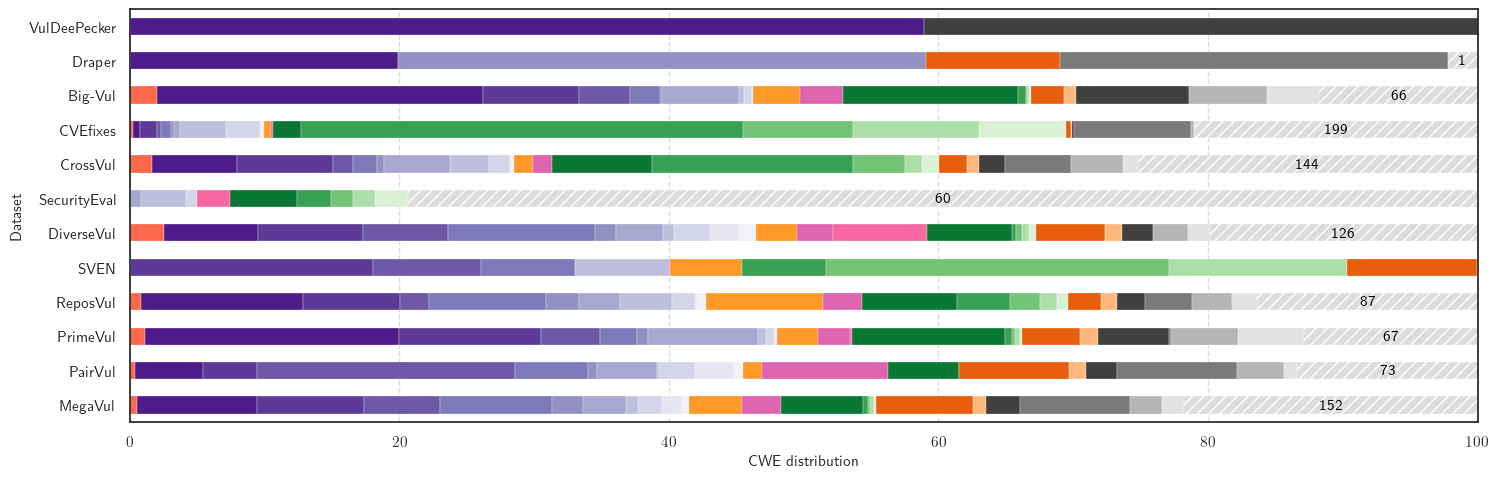

In [269]:
plt.rcParams['text.usetex'] = True
pillar_cwes = {pillars[p]: [] for p in pillars}
# Sort keys numerically, but put '000' (→ 'not mapped') last
pillar_order = [pillars[k] for k in sorted(pillars.keys(), key=lambda x: (x == '000', int(x)))]

# parse CWE XML tree
tree = ET.parse("1000.xml")
root = tree.getroot()
ns = {'cwe': 'http://cwe.mitre.org/cwe-7'} # XML namespace defined in 1000.xml

# build a map from CWE_ID to its children for quick traversal
cwe_children = {}
# collect all relationships
for weakness in root.findall('.//cwe:Weaknesses/cwe:Weakness', ns):
    cwe_id = weakness.attrib['ID']
    related_weaknesses = weakness.find('cwe:Related_Weaknesses', ns)
    if related_weaknesses is not None:
        for rel in related_weaknesses.findall('cwe:Related_Weakness', ns):
            if rel.attrib['Nature'] == 'ChildOf' and rel.attrib['View_ID'] == '1000':
                parent_id = rel.attrib['CWE_ID']
                if parent_id not in cwe_children:
                    cwe_children[parent_id] = []
                cwe_children[parent_id].append(cwe_id)

# collect all descendants
def collect_descendants(cwe_id, collected):
    if cwe_id in cwe_children:
        for child in cwe_children[cwe_id]:
            if child not in collected:
                collected.add(child)
                collect_descendants(child, collected)

# populate result structure
for pillar_id in pillars:
    descendants = set()
    collect_descendants(pillar_id, descendants)
    pillar_cwes[pillars[pillar_id]] = sorted(descendants)

# Add each pillar_id in the list
for pillar_id, pillar_name in pillars.items():
    pillar_cwes[pillar_name].append(pillar_id)

#for pillar, cwes in pillar_cwes.items():
#    print(f"{pillar} ({len(cwes)} CWEs): {cwes}")


# --- Map datasets to pillars ---
# datasets and pillar set up
df_cwe_stats_all = pd.concat([
    df_vdp_cwe_stats,
    df_draper_cwe_stats,
    df_bigvul_cwe_stats,
    df_cvefixes_cwe_stats,
    df_crossvul_cwe_stats,
    df_securityeval_cwe_stats,
    df_diversevul_cwe_stats,
    df_sven_cwe_stats,
    df_reposvul_cwe_stats,
    df_pairvul_cwe_stats,
    df_primevul_cwe_stats,
    df_megavul_cwe_stats
], ignore_index=True)

# normalize cwe labels:
# - remove leading zero (e.g., CWE-020 → CWE-20)
# - convert all to uppercase (cwe-20 → CWE-20)
# - map other/no-info ...
def normalize_cwe(cwe):
    if pd.isna(cwe):  # handle NaN
        return None
    cwe = str(cwe).strip().upper()
    # If CWE label contains "other", "noinfo", or "none", map to CWE-OTHER
    if any(x in cwe for x in ['OTHER', 'NOINFO', 'NONE']):
        return 'CWE-OTHER'
    # normalize CWE-xxx
    match = re.match(r'CWE-(0*)(\d+)', cwe)
    return f'CWE-{match.group(2)}' if match else cwe

df_cwe_stats_all['cwe'] = df_cwe_stats_all['cwe'].apply(normalize_cwe)
df_cwe_stats_all = df_cwe_stats_all.dropna(subset=['cwe'])

# cwe_to_pillar lookup
cwe_to_pillar = {}
for pillar, cwe_list in pillar_cwes.items():
    for cwe in cwe_list:
        cwe_to_pillar[f'CWE-{int(cwe)}'] = pillar  # format like 'CWE-20'

# identify all CWEs not mapped by CWE-1000 view
all_cwes = set(df_cwe_stats_all['cwe'].unique())
mapped_cwes = set(cwe_to_pillar.keys())
unmapped_cwes = all_cwes - mapped_cwes
# assign to 'not mapped' pillar
for cwe in unmapped_cwes:
    cwe_to_pillar[cwe] = 'not mapped'
    pillar_cwes['not mapped'].append(cwe.split('-')[1])  # Add only number part


# --- Plot parameters ---
# plot cwe distribution
# Get top N CWEs
#############
#############
N = 25 # 25 # 'all' # number or 'all'
#############
#############

if N != 'all':
    # Total distinct CWEs in each dataset (before filtering to top N)
    total_cwe_counts = df_cwe_stats_all.groupby('dataset')['cwe'].nunique()
    top_cwes = df_cwe_stats_all.groupby('cwe')['count'].sum().sort_values(ascending=False).head(N).index
    top_cwe_counts = df_cwe_stats_all[df_cwe_stats_all['cwe'].isin(top_cwes)].groupby('dataset')['cwe'].nunique()
    df_cwe_stats_all = df_cwe_stats_all[df_cwe_stats_all['cwe'].isin(top_cwes)]

# Aggregate
df_agg = df_cwe_stats_all.groupby(['dataset', 'cwe'])['percentage'].sum().reset_index()

# Pivot for plotting
pivot_df = df_agg.pivot(index='dataset', columns='cwe', values='percentage').fillna(0)
# --- Reorder datasets in plot ---
custom_dataset_order = ['MegaVul', 'PairVul', 'PrimeVul', 'ReposVul', 'SVEN', 'DiverseVul', 'SecurityEval', 'CrossVul', 'CVEfixes', 'Big-Vul', 'Draper', 'VulDeePecker']
pivot_df = pivot_df.loc[custom_dataset_order]

# # select only subset of datasets
# custom_dataset_order_selected = ['MegaVul', 'PrimeVul', 'DiverseVul', 'SecurityEval', 'CrossVul', 'CVEfixes', 'Big-Vul']
# df_agg = df_agg[df_agg['dataset'].isin(custom_dataset_order_selected)]


# --- Group CWEs by pillar ---
grouped_cwes = {}
for cwe in pivot_df.columns:
    pillar = cwe_to_pillar.get(cwe, 'not mapped')
    grouped_cwes.setdefault(pillar, []).append(cwe)

# sort by share instead of CWE-ID
cwe_total_percentage = df_agg.groupby('cwe')['percentage'].sum()

# --- Sort CWEs by: ---
# 1. Pillar order
# 2. Percentage (descending) within pillar
def sort_key(cwe):
    pillar = cwe_to_pillar.get(cwe, 'not mapped')
    pillar_idx = pillar_order.index(pillar) if pillar in pillar_order else float('inf')
    percentage = -cwe_total_percentage.get(cwe, 0)
    return (pillar_idx, percentage)

col_order = sorted(pivot_df.columns, key=sort_key)
pivot_df = pivot_df[col_order]
for pillar in grouped_cwes:
    grouped_cwes[pillar] = sorted(
        grouped_cwes[pillar],
        key=lambda cwe: -cwe_total_percentage.get(cwe, 0)
    )

cwe_colors = {}
for pillar, cmap_name in pillar_colors.items():
    pillar_cwes_in_plot = [cwe for cwe in pivot_df.columns if cwe_to_pillar.get(cwe) == pillar]
    cmap = plt.get_cmap(cmap_name)
    for i, cwe in enumerate(reversed(pillar_cwes_in_plot)):  # dark to light
        if N == 'all':
            cwe_colors[cwe] = cmap(0.75) # cmap((i + 1) / (len(pillar_cwes_in_plot) + 1) - 0.2) # when using all - 0.02)
        else:
            cwe_colors[cwe] = cmap((i + 1) / (len(pillar_cwes_in_plot) + 1))

if N != 'all':
    # Add remainder
    top_covered = pivot_df.sum(axis=1)
    remainder_counts = (total_cwe_counts - top_cwe_counts).clip(lower=0)
    pivot_df['__REMAINDER__'] = (100 - top_covered).clip(lower=0)

    # Assign remainder color and push to end of plotting order
    cwe_colors['__REMAINDER__'] = '#dddddd'
    plot_columns = list(pivot_df.columns)
    plot_columns.remove('__REMAINDER__')
    plot_columns.append('__REMAINDER__')
    pivot_df = pivot_df[plot_columns]
else:
    plot_columns = list(pivot_df.columns)



# --- Plot ---
fig, ax = plt.subplots(figsize=(_FIGSIZE_WIDTH,5.5)) # top 25: figsize=(18.2033,8)
pivot_df.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color= [cwe_colors[cwe] for cwe in plot_columns], #[cwe_colors.get(cwe) for cwe in pivot_df.columns],
    edgecolor='white', 
    linewidth=0.2
)
if N != 'all':
    # add hatch to remainder
    for bar_container, cwe in zip(ax.containers, pivot_df.columns):
        if cwe == '__REMAINDER__':
            for bar in bar_container:
                bar.set_hatch('///')  # or '\\\\' or 'xxx' etc.

ax.set_xlabel('CWE distribution', fontsize=_FONTSIZE_AXIS_LABELS)
ax.set_ylabel('Dataset', fontsize=_FONTSIZE_AXIS_LABELS)
ax.tick_params(axis='y', labelsize=_FONTSIZE_TICKS)
ax.xaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Grid behind bars
ax.set_xlim([0, 100])

# --- Add annotations: number of distinct CWEs per pillar per dataset ---
if N == 'all':
    for idx, dataset in enumerate(pivot_df.index):
        start = 0
        for pillar in pillar_order:
            cwes = grouped_cwes.get(pillar, [])
            cwes_in_dataset = [cwe for cwe in cwes if pivot_df.at[dataset, cwe] > 0]
            if not cwes_in_dataset:
                continue
            width = sum(pivot_df.at[dataset, cwe] for cwe in cwes_in_dataset)
            count = len(cwes_in_dataset)
            ax.text(start + width / 2, idx, str(count), ha='center', va='center', fontsize=_FONTSIZE_WITHIN_FIGURE, color='white')
            start += width
if N != 'all':
    for idx, dataset in enumerate(pivot_df.index):
        width = pivot_df.at[dataset, '__REMAINDER__']
        if width > 1:
            ax.text(100 - width / 2, idx, str(remainder_counts[dataset]), ha='center', va='center', fontsize=_FONTSIZE_WITHIN_FIGURE, color='black')


# --- Legend ---
if N == 'all':
    # --- Simplified Legend: One entry per Pillar ---
    pillar_only_handles = []
    for pillar in pillar_order:
        if pillar not in grouped_cwes:
            continue
        cmap_name = pillar_colors.get(pillar, 'Greys')
        cmap = plt.get_cmap(cmap_name)
        color = cmap(0.75)  # moderate color from the colormap
        pillar_only_handles.append(Patch(facecolor=color, edgecolor='none', label=pillar))

    plt.legend(
        handles=pillar_only_handles,
        bbox_to_anchor=(0.5, -0.3),
        loc='upper left',
        ncol=1,
        title='CWE-1000 Pillars',
        title_fontsize=_FONTSIZE_LEGEND,
        fontsize=_FONTSIZE_LEGEND,
        borderaxespad=0.0
    )

else:
    # --- Full Legend: Show all CWEs grouped by pillar ---
    legend_handles = []
    for pillar in pillar_order:
        if pillar not in grouped_cwes:
            continue
        label = f"\\textbf{{{pillar}}}"
        legend_handles.append(Patch(facecolor='none', edgecolor='none', label=label))
        for cwe in grouped_cwes[pillar]:
            legend_handles.append(Patch(facecolor=cwe_colors[cwe], label=cwe))

    plt.legend(
        handles=legend_handles,
        bbox_to_anchor=(0.5, -0.2),
        loc='upper center',
        ncol=3,
        title='Top 25 CWEs',
        title_fontsize=_FONTSIZE_LEGEND,
        fontsize=_FONTSIZE_LEGEND,
        borderaxespad=0.0
    )

ax.get_legend().remove()
plt.tight_layout(rect=[0, 0.1, 1, 1])
if N == 'all':
    plt.savefig("../figures/cwe_insights_all.pdf", format='pdf', bbox_inches='tight')
else:
    plt.savefig("../figures/cwe_insights_25_remainder.pdf", format='pdf', bbox_inches='tight')
plt.show()


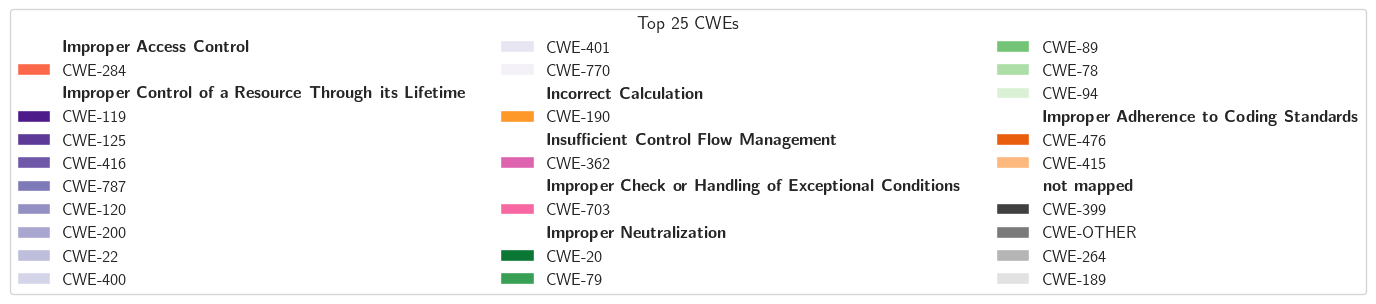

In [270]:
if N == 'all':
    fig, ax = plt.subplots(figsize=(_FIGSIZE_WIDTH, 1.6))
    ax.axis('off')  # Hide axes

    # Plot only the legend
    ax.legend(
        handles=pillar_only_handles,
        loc='center',
        ncol=3,
        title='Pillars',
        fontsize=_FONTSIZE_LEGEND,
        title_fontsize=_FONTSIZE_LEGEND+1,
        frameon=True
    )
    plt.tight_layout()
    plt.savefig("../figures/legend_pillars.pdf", format='pdf', bbox_inches='tight',dpi=400)
    plt.show()

else:
    fig, ax = plt.subplots(figsize=(_FIGSIZE_WIDTH, 3))
    ax.axis('off')  # Hide axes

    # Plot only the legend
    ax.legend(
        handles=legend_handles,
        loc='center',
        ncol=3,
        title='Top 25 CWEs',
        fontsize=_FONTSIZE_LEGEND,
        title_fontsize=_FONTSIZE_LEGEND+1,
        frameon=True
    )
    plt.tight_layout()
    plt.savefig("../figures/legend_CWEs.pdf", format='pdf', bbox_inches='tight',dpi=400)
    plt.show()


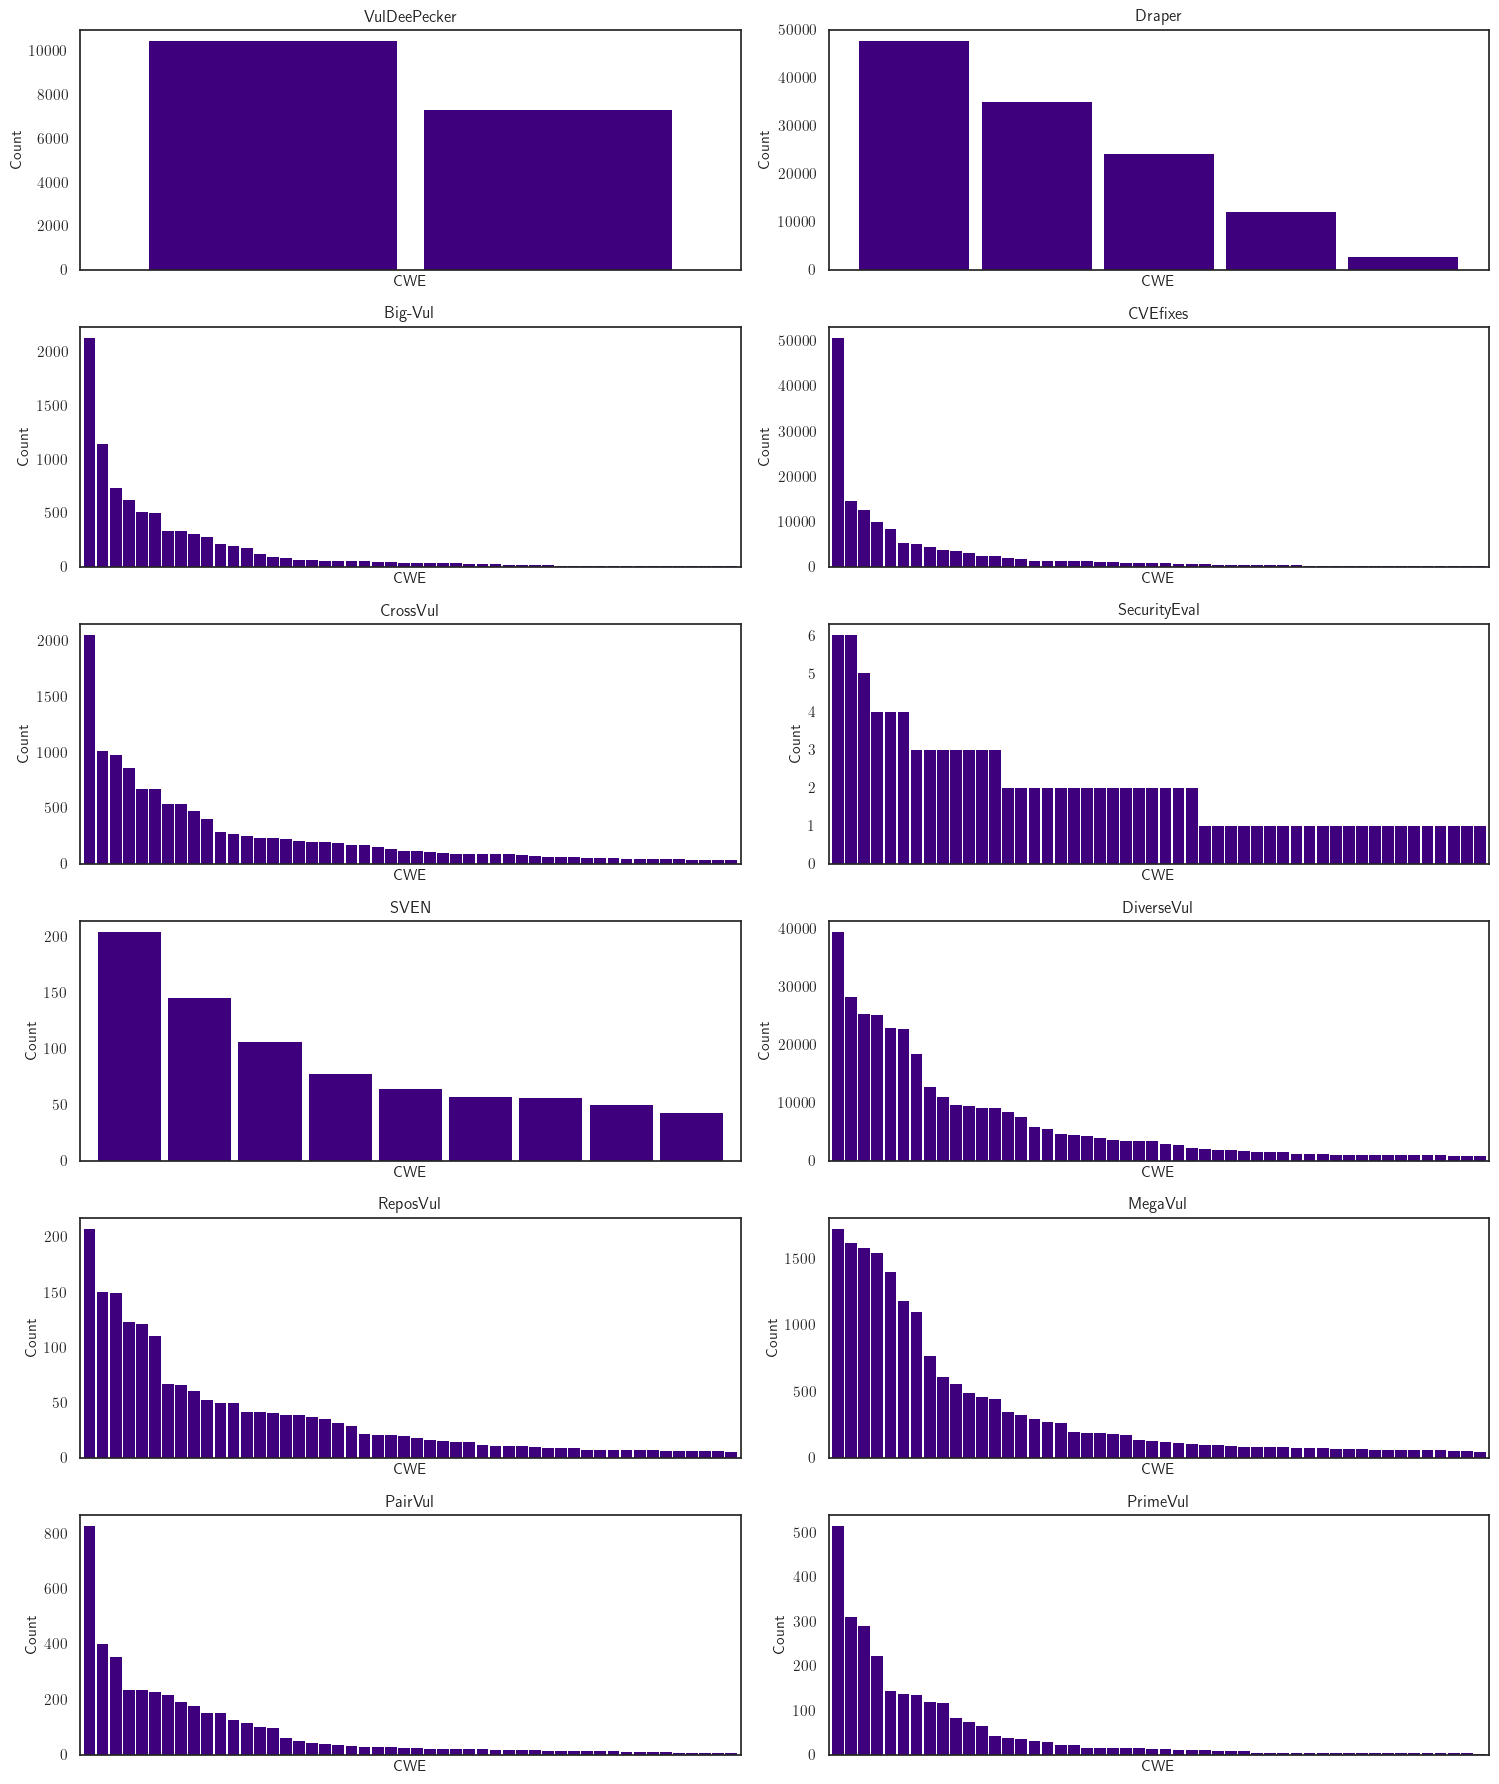

In [271]:
# visualize long tail distribution
df_cwe_stats_all = pd.concat([
    df_vdp_cwe_stats,
    df_draper_cwe_stats,
    df_bigvul_cwe_stats,
    df_cvefixes_cwe_stats,
    df_crossvul_cwe_stats,
    df_securityeval_cwe_stats,
    df_sven_cwe_stats,
    df_diversevul_cwe_stats,
    df_reposvul_cwe_stats,
    df_megavul_cwe_stats,
    df_pairvul_cwe_stats,
    df_primevul_cwe_stats
], ignore_index=True)
datasets = df_cwe_stats_all['dataset'].unique()

# Plot settings
fig, axes = plt.subplots(nrows=(len(datasets) + 1) // 2, ncols=2, figsize=(_FIGSIZE_WIDTH, 3 * ((len(datasets) + 1) // 2)))
axes = axes.flatten()

for i, dataset in enumerate(datasets):
    ax = axes[i]
    
    # Filter and group
    df_subset = df_cwe_stats_all[df_cwe_stats_all['dataset'] == dataset]
    cwe_counts = df_subset.groupby('cwe')['count'].sum().sort_values(ascending=False).head(50)
    
    # Bar plot
    cwe_counts.plot(kind='bar', ax=ax, color='#3F007D', edgecolor='none', width=0.9)
    ax.set_title(dataset)
    ax.set_ylabel("Count", fontsize=_FONTSIZE_AXIS_LABELS)
    ax.set_xlabel("CWE", fontsize=_FONTSIZE_AXIS_LABELS)
    ax.set_xticks([])
    #ax.tick_params(axis='x', labelrotation=90)
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


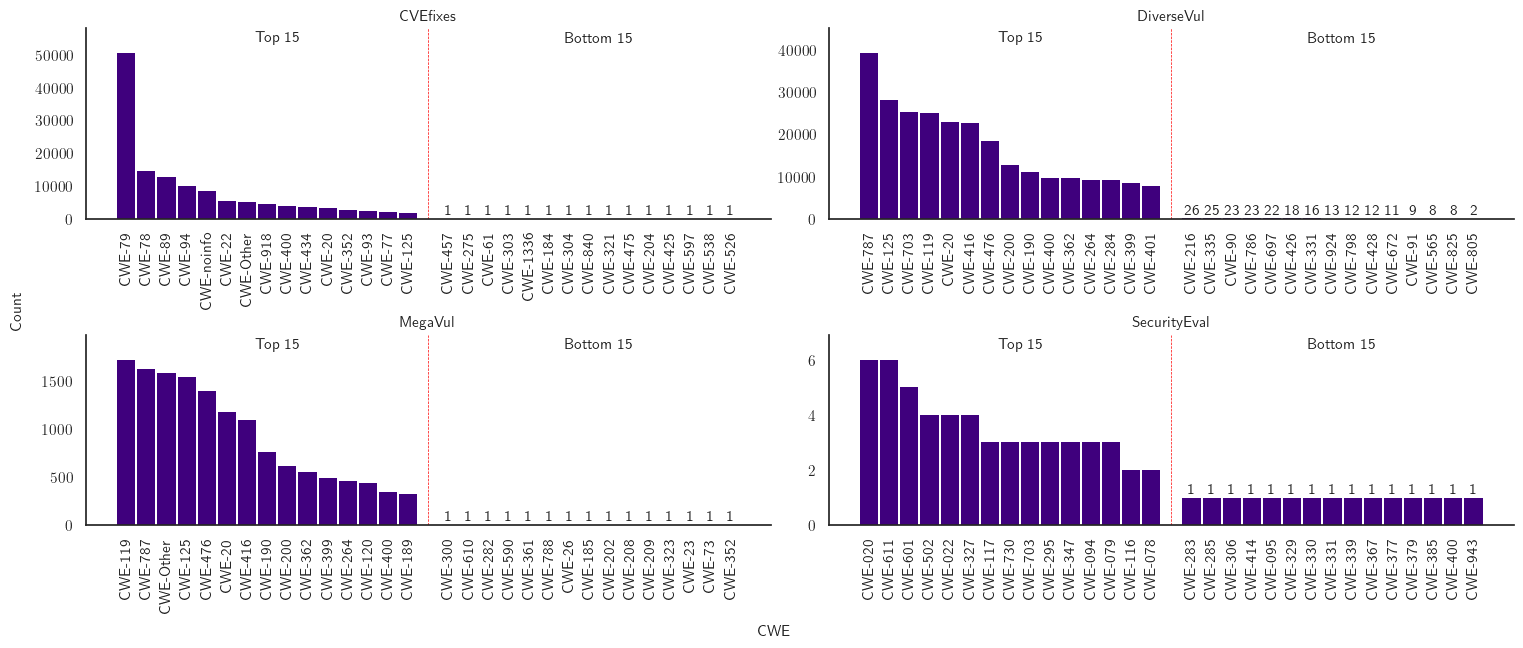

In [272]:
# Parameters
top_x = 15
bottom_x = 15
selected_datasets = ['CVEfixes', 'DiverseVul', 'MegaVul', 'SecurityEval']
filtered_df = df_cwe_stats_all[df_cwe_stats_all['dataset'].isin(selected_datasets)]

# Set up 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(_FIGSIZE_WIDTH, _FIGSIZE_HEIGHT), sharex=False)
axes = axes.flatten()

for ax, dataset in zip(axes, selected_datasets):
    data = filtered_df[filtered_df['dataset'] == dataset]
    cwe_counts = data.groupby('cwe')['count'].sum().sort_values(ascending=False)

    # Select top and bottom CWEs
    top_counts = cwe_counts.head(top_x)
    bottom_counts = cwe_counts.tail(bottom_x)
    
    labels = list(top_counts.index) + list(bottom_counts.index)
    values = list(top_counts.values) + list(bottom_counts.values)
    
    gap = 1
    x_top = list(range(top_x))
    x_bottom = list(range(top_x + gap, top_x + gap + bottom_x))
    x_all = x_top + x_bottom

    # Plot bars
    ax.bar(x_top, top_counts.values, color='#3F007D', edgecolor='none', width=0.9)
    ax.bar(x_bottom, bottom_counts.values, color='#3F007D', edgecolor='none', width=0.9)

    # Text labels for bottom group
    for x, val in zip(x_bottom, bottom_counts.values):
        ax.text(x, val + max(values) * 0.01, f'{int(val)}', ha='center', va='bottom', fontsize=_FONTSIZE_WITHIN_FIGURE)

    ax.text(top_x / 2, max(values) * 1.05, "Top 15", ha='center', va='bottom', fontsize=_FONTSIZE_WITHIN_FIGURE)
    ax.text(top_x + gap + bottom_x / 2, max(values) * 1.05, "Bottom 15", ha='center', va='bottom', fontsize=_FONTSIZE_WITHIN_FIGURE)
    ax.set_ylim(top=max(values) * 1.15)

    if dataset == 'CVEfixes':
        labels = [lbl.replace('NVD-CWE-Other', 'CWE-Other').replace('NVD-CWE-noinfo', 'CWE-noinfo') for lbl in labels]

    if dataset == 'SecurityEval':
        ax.set_yticks([0, 2, 4, 6])

    # Vertical red line between groups
    ax.axvline(x=top_x + gap / 2 - 0.5, color='red', linestyle='--', linewidth=0.5)

    ax.set_xticks(x_all)
    ax.set_xticklabels(labels, rotation=90)

    # Title and labels
    ax.set_title(dataset, fontsize=_FONTSIZE_AXIS_LABELS)
    ax.tick_params(axis='y', labelsize=_FONTSIZE_TICKS)
    ax.tick_params(axis='x', labelsize=_FONTSIZE_TICKS)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout(h_pad=0.4, w_pad=0.4)

fig.text(0.5, 0, 'CWE', ha='center', va='center', fontsize=_FONTSIZE_AXIS_LABELS)         # outer x-axis label
fig.text(0, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=_FONTSIZE_AXIS_LABELS)  # outer y-axis label
plt.savefig("../figures/long_tail_tb_2x2.pdf", bbox_inches='tight', dpi=400)


In [273]:
# CWEs used in dataset
used_cwes = set(cwe.replace('CWE-', '') for cwe in all_cwes)

# All CWEs in CWE-1000
all_cwe1000_ids = set()
for ids in pillar_cwes.values():
    all_cwe1000_ids.update(ids)

# CWEs in CWE-1000 not used in any dataset
unused_cwes = sorted(all_cwe1000_ids - used_cwes, key=int)

print(f"{len(unused_cwes)} CWE-1000 CWEs are not represented in any dataset.")
print("Examples:", unused_cwes)

671 CWE-1000 CWEs are not represented in any dataset.
Examples: ['000', '5', '6', '7', '8', '9', '11', '12', '13', '14', '15', '24', '25', '28', '30', '31', '32', '33', '34', '35', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '62', '64', '65', '66', '67', '69', '72', '76', '81', '82', '83', '84', '85', '86', '97', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '123', '124', '127', '128', '130', '135', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '168', '170', '173', '174', '175', '176', '177', '179', '180', '181', '182', '183', '186', '187', '188', '192', '194', '195', '196', '198', '201', '205', '206', '207', '210', '211', '219', '220', '221', '222', '223', '224', '226', '228', '230', '232', '233', '234', '235', '236', '237', '2

In [274]:
# Parse CWE XML tree
tree = ET.parse("1000.xml")
root = tree.getroot()
ns = {'cwe': 'http://cwe.mitre.org/cwe-7'}  # XML namespace defined in 1000.xml

# Build a set of CWE IDs with 'Vulnerability Mapping: ALLOWED'
allowed_cwes = set()
for weakness in root.findall('.//cwe:Weaknesses/cwe:Weakness', ns):
    cwe_id = weakness.attrib['ID']
    mapping_notes = weakness.find('cwe:Mapping_Notes', ns)
    if mapping_notes is not None:
        usage_elem = mapping_notes.find('cwe:Usage', ns)
        if usage_elem is not None and usage_elem.text.strip().upper() == 'ALLOWED':
            allowed_cwes.add(cwe_id)

# Filter unused CWEs that are allowed for vulnerability mapping
unused_allowed_cwes = sorted(set(unused_cwes) & allowed_cwes, key=int)

print(f"{len(unused_allowed_cwes)} unused CWE-1000 entries are allowed for vulnerability mapping.")
print("Examples:", unused_allowed_cwes[:10])


555 unused CWE-1000 entries are allowed for vulnerability mapping.
Examples: ['5', '6', '7', '8', '9', '11', '12', '13', '14', '15']


Improper Access Control: 166 CWEs
Improper Interaction Between Multiple Correctly-Behaving Entities: 16 CWEs
Improper Control of a Resource Through its Lifetime: 367 CWEs
Incorrect Calculation: 14 CWEs
Insufficient Control Flow Management: 84 CWEs
Protection Mechanism Failure: 100 CWEs
Incorrect Comparison: 22 CWEs
Improper Check or Handling of Exceptional Conditions: 59 CWEs
Improper Neutralization: 144 CWEs
Improper Adherence to Coding Standards: 195 CWEs
not mapped: 24 CWEs


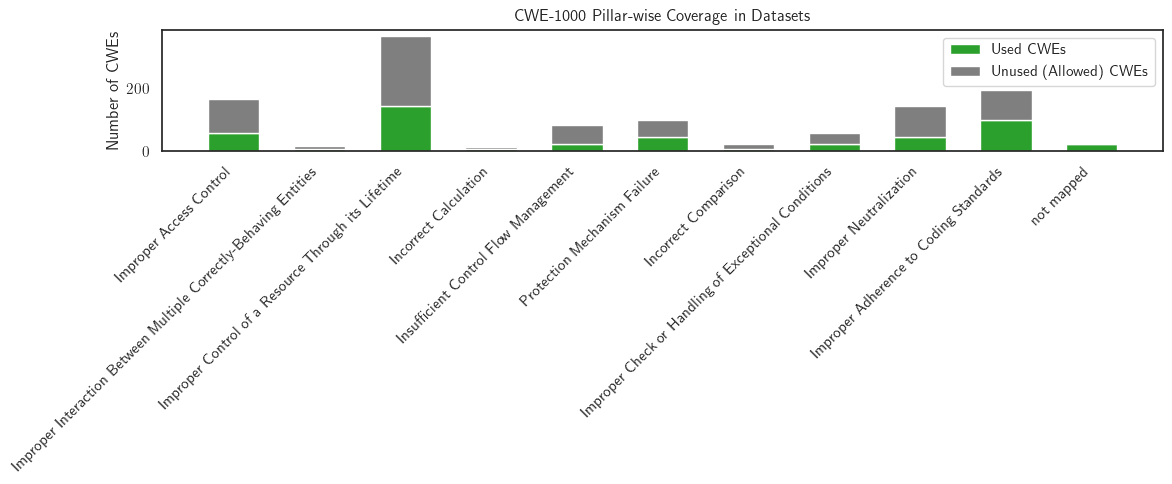

In [275]:
# Count total, used, unused per pillar
for pillar, cwes in pillar_cwes.items():
    print(f"{pillar}: {len(cwes)} CWEs")

pillar_coverage = []
for pillar in pillar_order:
    all_cwes = set(pillar_cwes[pillar])
    unused = set(unused_allowed_cwes) & all_cwes
    used = all_cwes - unused
    pillar_coverage.append({
        'pillar': pillar,
        'total': len(all_cwes),
        'used': len(used),
        'unused': len(unused),
    })

# Plot
labels = [p['pillar'] for p in pillar_coverage]
used_counts = [p['used'] for p in pillar_coverage]
unused_counts = [p['unused'] for p in pillar_coverage]

x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x, used_counts, width, label='Used CWEs', color='tab:green')
ax.bar(x, unused_counts, width, bottom=used_counts, label='Unused (Allowed) CWEs', color='tab:gray')

ax.set_ylabel('Number of CWEs')
ax.set_title('CWE-1000 Pillar-wise Coverage in Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


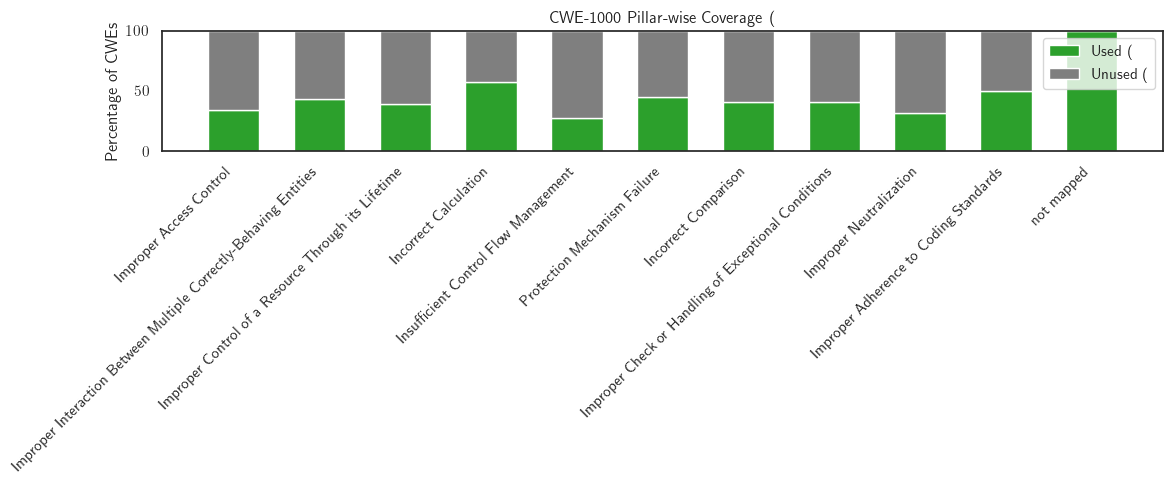

In [276]:
# Count total, used, unused per pillar
pillar_coverage = []
for pillar in pillar_order:
    all_cwes = set(pillar_cwes[pillar])
    unused = set(unused_allowed_cwes) & all_cwes
    used = all_cwes - unused
    pillar_coverage.append({
        'pillar': pillar,
        'total': len(all_cwes),
        'used': len(used),
        'unused': len(unused),
    })

# Plot
labels = [p['pillar'] for p in pillar_coverage]
used_perc = [p['used'] / p['total'] * 100 for p in pillar_coverage]
unused_perc = [p['unused'] / p['total'] * 100 for p in pillar_coverage]

x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x, used_perc, width, label='Used (%)', color='tab:green')
ax.bar(x, unused_perc, width, bottom=used_perc, label='Unused (%)', color='tab:gray')

ax.set_ylabel('Percentage of CWEs')
ax.set_title('CWE-1000 Pillar-wise Coverage (% Used vs. Unused)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()
